In [1]:
import warnings, pickle, os, itertools

import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 300)

from IPython.display import display
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(rc={'figure.figsize':(10,10)})
plt.rc("axes", titlesize=14, labelsize=14)
plt.rc('figure', titlesize=16)

import shap
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

%load_ext autoreload
%autoreload 1

In [2]:
from utils.evaluation import *
from models import *
from systematic_comparison import get_xy
%aimport utils.evaluation, models, systematic_comparison

In [3]:
class Notebook:
    SYS_RESULTS_DIR = 'models/tough_with_h1_filtered/'
    TIME_RESULTS_DIR = 'models/time_tough_with_h1_filtered/'
    TIME_PERSISTED_RESULTS_DIR = 'models/time_far_short'
    IMAGE_DIR = 'results/images/tough_h1'

def load_results(directory, exclude=['OneClassSVM', 'IsolationForest']):
    result_files = [f'{directory}/{_}' for _ in os.listdir(directory) if _.endswith('.h5')]
    y_preds = pd.concat([pd.read_hdf(_, 'y_preds') for _ in result_files], axis=1)
    metrics = pd.concat([pd.read_hdf(_, 'metrics') for _ in result_files], axis=0).reset_index(drop=True)
    # hyperparameters = {name: optuna.load_study(study_name = name, storage=Notebook.STORAGE).best_params for name in metrics.name.values}

    if len(exclude):
        metrics = metrics[~metrics.estimator.isin(exclude)].copy()
        y_preds = y_preds[metrics.name.values].copy()

    return metrics, y_preds

def load_model(name, directory):
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        with open(f'{directory}/models/{name}.bin', 'rb') as file:
            return pickle.load(file)

In [4]:
from sklearn.model_selection import train_test_split
from dataset import SCIData, SCICols
%aimport dataset

sci = SCIData.load('data/sci.h5')

scii = (
    SCIData(
        SCIData.quickload("data/sci_processed.h5").sort_values("AdmissionDateTime")
    )
    .mandate(SCICols.news_data_raw)
    .augment_shmi(onehot=True)
    .derive_ae_diagnosis_stems(onehot=False)
    .derive_critical_event(within=1, return_subcols=True)
)
scii = SCIData(scii[~((scii.BreathingDevice=='NIV - NIV')&(scii.AdmitWard=='HH1M'))].copy())

sci_train, sci_test = train_test_split(
    scii,
    test_size=0.33,
    random_state=42,
    shuffle=False,
)
sci_train, sci_test = SCIData(sci_train), SCIData(sci_test)

In [5]:
select_num_cols = dict(
    Age='Age (years)', 
    TotalLOS='LOS (days)',
  #  ReadmissionTimespan='Readmission',
    NEWS_score='NEWS',
    O2_saturation='SpO2 (%)',
    Respiration_rate='RR (breaths/min)',
    HeartRate='Pulse (beats/min)',
    SystolicBP='Systolic BP (mmHg)',
    DiastolicBP='Diastolic BP (mmHg)',
    Temperature='Temperature (oC)',
    Haemoglobin='Haemoglobin (g/L)',
    Urea_serum='Urea (mmol/L)',
    Sodium_serum='Sodium (mmol/L)',
    Potassium_serum='Potassium (mEg/L)',
    Creatinine='Creatinine (mmol/L)',
    Oxygen_flow_rate='FiO2 (%)'
)
select_binary_cols = dict(
    DiedWithin30Days = '30-day Mortality',
    DiedDuringStay = 'In-hospital Mortality',
    AVCPU_Alert = 'AVCPU-A',
    AssistedBreathing = 'Assisted Breathing',
    Female='Female',
    LyingDown='Lying Down',
    Nausea='Nausea',
    Pain='Pain',
    VomitingSinceLastRound='Vomiting',
    Readmission='Readmission',
    SentToSDEC='SDEC'
)
select_feature_groups = dict(
    news='Vitals',
    news_with_phenotype='& Obs',
    with_labs='& Labs',
    with_notes_and_labs='& Notes',
    with_notes_labs_and_hospital='& Services'
)
select_scored_feature_groups = dict(
    news_scores='Vitals',
    news_scores_with_phenotype='& Obs',
    scores_with_labs='& Labs',
    scores_with_notes_and_labs='& Notes',
    scores_with_notes_labs_and_hospital='& Services'
)
pretty_print_models = dict(
    LogisticRegression='LR',
    L1Regression='LR-L1',
    L2Regression='LR-L2',
    ElasticNetRegression='LR-EN',
    XGBoost='XGBoost',
    LightGBM='LightGBM',
    LinearSVM='LinearSVM'
)
select_categorical_cols = dict(
    AdmissionMethodDescription='Admission Pathway',
    AdmissionSpecialty='Admission Specialty',
    AandEPresentingComplaint='Presenting Complaint',
    BreathingDevice='Breathing Device',
    AandEMainDiagnosis='A&E Diagnosis'
)
pretty_print_categoricals = {
    'collaps': 'collaps-',
    'dizz': 'dizz-',
    'BOOKED ADMISSION ': 'Booked Adm.',
    'EMERGENCY OPD': 'Emg. OPD',
    'EMERGENCY A+E': 'Emg. A&E',
    'EMERGENCY GP REFER': 'Emg. GP Ref.',
    'NON EM TRAN OTH PROV': 'Non-Emg. Transf.',
    'ACCIDENT & EMERGENCY': 'A&E',
    'ACUTE INTERNAL MEDICINE': 'Acute Int. Med.',
    'GENERAL SURGERY': 'Gen. Surgery',
    'NEPHROLOGY': 'Nephrology',
    'TRAUMA & ORTHOPAEDICS': 'Trauma & Ortho.',
    'EMERG TRAN OTH PROV': 'Emg. Tran. Oth. Prov.',
    'ELECTIVE PLANNED': 'Elective Booked',
    'GENERAL MEDICINE': 'General Med.',
    'RESPIRATORY MEDICINE': 'Respiratory Med.',
    'GERIATRIC MEDICINE': 'Geriatric Med.',
    'BARIATRIC SURGERY': 'Bariatric Surg.',
    'SPINAL SURGERY SERVICE': 'Spinal Surg. Svc.',
    'GASTROENTEROLOGY': 'Gastro.',
    'NEUROSURGERY': 'Neurosurgery',
    'UROLOGY': 'Urology',
    'STROKE NEUROLOGY': 'Stroke Neuro.',
    'GYNAECOLOGY': 'Gyno.',
    'abscesses and local infections': 'local infections'
}

In [6]:
unseen_idx = sci_test[~sci_test.PatientNumber.isin(sci_train.PatientNumber)].index
seen_idx = sci_test[sci_test.PatientNumber.isin(sci_train.PatientNumber)].index

## Dataset

In [134]:
def summarise_numerical_variables():
    df = SCIData(scii.copy())
    df['AdmissionDateTime'] = df.AdmissionDateTime.dt.year
    df = df.derive_critical_event(within=9999, return_subcols=True)
    dfs = {
        'Total': df,
        'Training': df.loc[sci_train.index],
        'Test (Complete)': df.loc[sci_test.index],
        'Test (Unseen)': df.loc[unseen_idx]
    }

    groups = {
        'Vitals': scii.feature_groups['news'] + ['NEWS_score'],
        'Supplemental Observations & Phenotype': scii.feature_groups['news_extended'] + scii.feature_groups['phenotype'],
        'Labs': scii.feature_groups['labs'],
        'Service Utilisation': scii.feature_groups['hospital'],
        'Outcomes': ['DiedDuringStay', 'DiedWithin30Days', 'CriticalCare', 'CriticalEvent'],
        'Episode':['TotalLOS']
    }

    bin_cols = select_binary_cols | {
        'CriticalCare': 'Critical Care',
        'CriticalEvent': 'Critical Events'
    }
    group_lookup = {}
    for name, group in groups.items():
        group_lookup.update({_:name for _ in group})

    r = [dict(
            Dataset=dfname,
            Variable=vname,
            Group=group_lookup[vcol],
            Summary=f'{df[vcol].median():.2f} ({df[vcol].quantile(0.25):.2f}-{df[vcol].quantile(0.75):.2f})'.replace('.00','')
        ) for vcol, vname in select_num_cols.items() for dfname, df in dfs.items()] + [dict(
            Dataset=dfname,
            Variable=vname,
            Group=group_lookup[vcol],
            Summary=f'{df[vcol].sum()} ({df[vcol].sum()/df[vcol].shape[0]*100:.2f}%)'.replace('.00', '')
        ) for vcol, vname in bin_cols.items() for dfname, df in dfs.items()]
    
    for dfname, df in dfs.items():
        r += [dict(
            Dataset=dfname,
            Variable='Records',
            Group='Episode',
            Summary=df.shape[0]
        ), dict(
            Dataset=dfname,
            Variable='Patients',
            Group='Episode',
            Summary=df.PatientNumber.unique().shape[0]
        )]
    
    return pd.DataFrame(r).pivot(index=['Group', 'Variable'], columns='Dataset', values='Summary').loc[['Episode', 'Outcomes', 'Vitals', 'Supplemental Observations & Phenotype', 'Labs', 'Service Utilisation']][['Total', 'Training', 'Test (Complete)', 'Test (Unseen)']]
    

r = summarise_numerical_variables()
r

Dataset                                                                 Total  \
Group                                 Variable                                  
Episode                               LOS (days)             2.27 (0.65-7.13)   
                                      Patients                          62162   
                                      Records                          121058   
Outcomes                              30-day Mortality           3967 (3.28%)   
                                      Critical Care              4012 (3.31%)   
                                      Critical Events            8341 (6.89%)   
                                      In-hospital Mortality      5124 (4.23%)   
Vitals                                AVCPU-A                 119493 (98.71%)   
                                      Assisted Breathing       12167 (10.05%)   
                                      NEWS                            1 (0-2)   
                                      Pulse (beats/min)            80 (70-90)   
                                      RR (breaths/min)             17 (16-18)   
                                      SpO2 (%)                     97 (96-98)   
                                      Systolic BP (mmHg)        124 (113-139)   
                                      Temperature (oC)       36.70 (36.40-37)   
Supplemental Observations & Phenotype Age (years)                  69 (50-82)   
                                      Diastolic BP (mmHg)          70 (60-80)   
                                      Female                   63414 (52.38%)   
                                      FiO2 (%)                        0 (0-0)   
                                      Lying Down               56565 (46.73%)   
                                      Nausea                     1934 (1.60%)   
                                      Pain                   18504.0 (15.29%)   
                                      Vomiting                    607 (0.50%)   
Labs                                  Creatinine (mmol/L)         79 (63-105)   
                                      Haemoglobin (g/L)         130 (114-143)   
                                      Potassium (mEg/L)      4.20 (3.90-4.50)   
                                      Sodium (mmol/L)           138 (135-140)   
                                      Urea (mmol/L)          6.40 (4.60-9.60)   
Service Utilisation                   Readmission              15387 (12.71%)   
                                      SDEC                     29096 (24.03%)   

Dataset                                                              Training  \
Group                                 Variable                                  
Episode                               LOS (days)             2.06 (0.63-6.68)   
                                      Patients                          44752   
                                      Records                           81108   
Outcomes                              30-day Mortality           2589 (3.19%)   
                                      Critical Care              2822 (3.48%)   
                                      Critical Events            5489 (6.77%)   
                                      In-hospital Mortality      3233 (3.99%)   
Vitals                                AVCPU-A                  80013 (98.65%)   
                                      Assisted Breathing         7835 (9.66%)   
                                      NEWS                            1 (0-2)   
                                      Pulse (beats/min)            80 (70-90)   
                                      RR (breaths/min)             17 (16-18)   
                                      SpO2 (%)                     97 (96-98)   
                                      Systolic BP (mmHg)        122 (112-138)   
                                      Temperature (oC)       36.70 (36.40-37)   
Supplemental Observations & Ph

In [135]:
print(r.to_latex(multirow=True, column_format='llrrrr', bold_rows=True))

\begin{tabular}{llrrrr}
\toprule
                    & \textbf{Dataset} &             Total &          Training &   Test (Complete) &     Test (Unseen) \\
\textbf{Group} & \textbf{Variable} &                   &                   &                   &                   \\
\midrule
\multirow{3}{*}{\textbf{Episode}} & \textbf{LOS (days)} &  2.27 (0.65-7.13) &  2.06 (0.63-6.68) &  2.88 (0.71-8.49) &  2.20 (0.55-7.50) \\
                    & \textbf{Patients} &             62162 &             44752 &             25549 &             17410 \\
                    & \textbf{Records} &            121058 &             81108 &             39950 &             23075 \\
\cline{1-6}
\multirow{4}{*}{\textbf{Outcomes}} & \textbf{30-day Mortality} &      3967 (3.28\%) &      2589 (3.19\%) &      1378 (3.45\%) &          692 (3\%) \\
                    & \textbf{Critical Care} &      4012 (3.31\%) &      2822 (3.48\%) &      1190 (2.98\%) &       716 (3.10\%) \\
                    & \textbf{Critical E

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.


In [34]:
select_num_cols_values = {
    _:scii[_] for _ in select_num_cols.keys()
} | dict(
    Oxygen_flow_rate = scii.Oxygen_flow_rate*100
   # ReadmissionTimespan = scii.ReadmissionTimespan.dt.days
)

pd.DataFrame([{
    'Variable': select_num_cols[k],
    'Mean +- Std': f'{v.mean():.2f} ± {v.std():.2f}',
    'Min': round(v.min(), 2),
    'Max': round(v.max(), 2)
} for k, v in select_num_cols_values.items()]).set_index('Variable')


,Mean +- Std,Min,Max
Variable,,,
Age (years),64.99 ± 20.48,0.0,121.00
LOS (days),6.82 ± 14.96,0.0,1491.17
NEWS,1.20 ± 1.67,0.0,18.00
SpO2 (%),96.58 ± 2.55,48.0,100.00
RR (breaths/min),17.67 ± 2.50,7.0,77.00
Pulse (beats/min),80.85 ± 15.42,26.0,194.00
Systolic BP (mmHg),126.74 ± 19.71,52.0,270.00
Diastolic BP (mmHg),70.15 ± 12.40,22.0,198.00
Temperature (oC),36.76 ± 0.51,30.8,41.10


In [136]:
def summarise_categorical_variables():
    df = SCIData(scii.copy())
    for col in select_categorical_cols.keys():
        if col != 'AandEMainDiagnosis':
            df.loc[(~df[col].isin(df[col].value_counts().head(5).index)) & df[col].notna(), col] = 'Other'
    
    dfs = {
        'Total': df,
        'Training': df.loc[sci_train.index],
        'Test (Complete)': df.loc[sci_test.index],
        'Test (Unseen)': df.loc[unseen_idx]
    }

    r = [(df[vcol].value_counts().astype(str) + ' ('+
        (df[vcol].value_counts()/df[vcol].shape[0]*100).round(2).astype(str)+'%)')
        .to_frame(name='Summary')
        .reset_index()
        .assign(Variable=vname, Dataset=dfname)
        .rename(columns=dict(index='Value')).to_dict(orient='records')
        for vcol, vname in select_categorical_cols.items() for dfname, df in dfs.items()
    ]

    r = pd.DataFrame([__ for _ in r for __ in _])
    r.Value = r.Value.replace(pretty_print_categoricals)
    return r.pivot(index=['Variable', 'Value'], columns='Dataset', values='Summary').fillna("0 (0%)")[['Total', 'Training', 'Test (Complete)', 'Test (Unseen)']]

r = summarise_categorical_variables()
r

Dataset                                                       Total  \
Variable             Value                                            
A&E Diagnosis        collaps-                          1245 (1.03%)   
                     confus                             356 (0.29%)   
                     cope                               592 (0.49%)   
                     dementia                           227 (0.19%)   
                     diarrh                             326 (0.27%)   
                     dizz-                               89 (0.07%)   
                     fall                              1461 (1.21%)   
                     head                              2704 (2.23%)   
                     mobility                           102 (0.08%)   
                     pain                              7162 (5.92%)   
                     sudden                                1 (0.0%)   
                     tight                                 5 (0.0%)   
                     vomit                              296 (0.24%)   
Admission Pathway    Booked Adm.                       1807 (1.49%)   
                     Emg. A&E                       110627 (91.38%)   
                     Emg. GP Ref.                      5866 (4.85%)   
                     Emg. OPD                           898 (0.74%)   
                     Non-Emg. Transf.                  1180 (0.97%)   
                     Other                              680 (0.56%)   
Admission Specialty  A&E                             18319 (15.13%)   
                     Acute Int. Med.                 91025 (75.19%)   
                     Gen. Surgery                      2612 (2.16%)   
                     Nephrology                        3454 (2.85%)   
                     Other                             4415 (3.65%)   
                     Trauma & Ortho.                   1233 (1.02%)   
Breathing Device     A - Air                        108851 (89.92%)   
                     N - Nasal cannula                 8900 (7.35%)   
                     Other                             1797 (1.48%)   
                     RM - Reservoir mask                394 (0.33%)   
                     SM - Simple mask                   685 (0.57%)   
                     V28 - Venturi 28%                  391 (0.32%)   
Presenting Complaint Other                           36819 (30.41%)   
                     abdominal pain in adults           6413 (5.3%)   
                     chest pain                       11585 (9.57%)   
                     falls                             5278 (4.36%)   
                     other                           31485 (26.01%)   
                     shortness of breath in adults   14865 (12.28%)   

Dataset                                                   Training  \
Variable             Value                                           
A&E Diagnosis        collaps-                         1245 (1.53%)   
                     confus                            356 (0.44%)   
                     cope                              348 (0.43%)   
                     dementia                            85 (0.1%)   
                     diarrh                             325 (0.4%)   
                     dizz-                              89 (0.11%)   
                     fall                              1461 (1.8%)   
                     head                             1992 (2.46%)   
                     mobility                          102 (0.13%)   
                     pain                              7139 (8.8%)   
                     sudden                               1 (0.0%)   
                     tight                               5 (0.01%)   
                     vomit                             264 (0.33%)   
Admission Pathway    Booked Adm.                       899 (1.11%)   
                     Emg. A&E                       74530 (91.89%)   
                     Emg. GP Ref.       

In [137]:
print(r.to_latex(multirow=True, bold_rows=True, column_format='llrrrr'))

\begin{tabular}{llrrrr}
\toprule
                     & \textbf{Dataset} &            Total &        Training & Test (Complete) &   Test (Unseen) \\
\textbf{Variable} & \textbf{Value} &                  &                 &                 &                 \\
\midrule
\multirow{13}{*}{\textbf{A\&E Diagnosis}} & \textbf{collaps-} &     1245 (1.03\%) &    1245 (1.53\%) &          0 (0\%) &          0 (0\%) \\
                     & \textbf{confus} &      356 (0.29\%) &     356 (0.44\%) &          0 (0\%) &          0 (0\%) \\
                     & \textbf{cope} &      592 (0.49\%) &     348 (0.43\%) &     244 (0.61\%) &     150 (0.65\%) \\
                     & \textbf{dementia} &      227 (0.19\%) &       85 (0.1\%) &     142 (0.36\%) &      80 (0.35\%) \\
                     & \textbf{diarrh} &      326 (0.27\%) &      325 (0.4\%) &        1 (0.0\%) &          0 (0\%) \\
                     & \textbf{dizz-} &       89 (0.07\%) &      89 (0.11\%) &          0 (0\%) &          0 (0\%

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.


In [37]:
select_categorical_cols_values = {
    _:scii[_] for _ in select_categorical_cols.keys()
} | dict(
)

In [38]:
pd.concat([(
    (v.value_counts().head(5).astype(str) + ' ('+
    (v.value_counts().head(5)/v.shape[0]*100).round(2).astype(str)+'%)')
    .to_frame(name='n (%)')
    .reset_index()
    .assign(Column=select_categorical_cols[k])
    .set_index(['Column', 'index'])
) for k, v in select_categorical_cols_values.items()])

n (%)
Column               index                                         
Admission Pathway    EMERGENCY A+E                  110627 (91.38%)
                     EMERGENCY GP REFER                5866 (4.85%)
                     BOOKED ADMISSION                  1807 (1.49%)
                     NON EM TRAN OTH PROV              1180 (0.97%)
                     EMERGENCY OPD                      898 (0.74%)
Admission Specialty  ACUTE INTERNAL MEDICINE         91025 (75.19%)
                     ACCIDENT & EMERGENCY            18319 (15.13%)
                     NEPHROLOGY                        3454 (2.85%)
                     GENERAL SURGERY                   2612 (2.16%)
                     TRAUMA & ORTHOPAEDICS             1233 (1.02%)
Presenting Complaint other                           31485 (26.01%)
                     shortness of breath in adults   14865 (12.28%)
                     chest pain                       11585 (9.57%)
                     abdominal pain in adults           6413 (5.3%)
                     falls                             5278 (4.36%)
Breathing Device     A - Air                        108851 (89.92%)
                     N - Nasal cannula                 8900 (7.35%)
                     SM - Simple mask                   685 (0.57%)
                     RM - Reservoir mask                394 (0.33%)
                     V28 - Venturi 28%                  391 (0.32%)
A&E Diagnosis        pain                              7162 (5.92%)
                     head                              2704 (2.23%)
                     fall                              1461 (1.21%)
                     collaps                           1245 (1.03%)
                     cope                               592 (0.49%)

In [138]:
print(f'Patients appearing in both: {np.isin(sci_train.PatientNumber.unique(), sci_test.PatientNumber.unique()).sum()}={np.isin(sci_train.PatientNumber.unique(), sci_test.PatientNumber.unique()).sum()/scii.PatientNumber.unique().shape[0]*100:.2f}%')
print(f'Number of episodes: {sci_test.PatientNumber.isin(sci_train.PatientNumber).sum()} = {sci_test.PatientNumber.isin(sci_train.PatientNumber).sum()/sci_test.shape[0]*100:.2f}%')


Patients appearing in both: 8139=13.09%
Number of episodes: 16875 = 42.24%


In [40]:
df = sci_train.groupby('PatientNumber').AdmissionDateTime.max().to_frame().join(
    sci_test.groupby('PatientNumber').AdmissionDateTime.min(), lsuffix='_train', rsuffix='_test'
).dropna()
num = (df.AdmissionDateTime_test - df.AdmissionDateTime_train < pd.Timedelta(days=30)).sum()
print(f'Patients where this happened within 30 days: {num} = {num/scii.PatientNumber.unique().shape[0]*100:.2f}%')

Patients where this happened within 30 days: 64 = 0.10%


In [41]:
pd.DataFrame(
    [
        dict(
            Subset=name,
            Start=df.AdmissionDateTime.min().strftime('%Y-%m-%d'),
            End=df.AdmissionDateTime.max().strftime('%Y-%m-%d'),
            Records=df.shape[0],
            Patients=df.PatientNumber.unique().shape[0],
            CriticalEvents=f'{df.CriticalEvent.sum()} ({round(df.CriticalEvent.sum()/df.shape[0]*100,2)}%)',
            Deaths=f'{df.DiedWithinThreshold.sum()} ({round(df.DiedWithinThreshold.sum()/df.shape[0]*100,2)}%)',
            CriticalCare=f'{df.CriticalCare.sum()} ({round(df.CriticalCare.sum()/df.shape[0]*100,2)}%)',
            Readmissions=f'{df.Readmission.sum()} ({round(df.Readmission.sum()/df.shape[0]*100,2)}%)',
        )
        for name, df in {
            'Training Set': sci_train, 
            'Testing Set': sci_test, 
            'Testing Set - Unseen': sci_test[~sci_test.PatientNumber.isin(sci_train.PatientNumber)],
            'Testing Set - Revisits': sci_test[sci_test.PatientNumber.isin(sci_train.PatientNumber)],
            'Total': scii
        }.items()
    ]
).set_index('Subset').T

Subset,Training Set,Testing Set,Testing Set - Unseen,Testing Set - Revisits,Total
Start,2015-01-01,2019-08-10,2019-08-10,2019-08-10,2015-01-01
End,2019-08-10,2022-03-31,2022-03-31,2022-03-31,2022-03-31
Records,81108,39950,23075,16875,121058
Patients,44752,25549,17410,8139,62162
CriticalEvents,2021 (2.49%),872 (2.18%),515 (2.23%),357 (2.12%),2893 (2.39%)
Deaths,219 (0.27%),116 (0.29%),65 (0.28%),51 (0.3%),335 (0.28%)
CriticalCare,1825 (2.25%),768 (1.92%),458 (1.98%),310 (1.84%),2593 (2.14%)
Readmissions,10732 (13.23%),4655 (11.65%),1919 (8.32%),2736 (16.21%),15387 (12.71%)


In [142]:
scii.PatientNumber.unique().shape[0]

62162

In [26]:
import matplotlib.cm as cm
def plot_clustered_stacked(dfall, labels=None, legend_titles=[None, None], title="multiple stacked bar plot",  H=['','//', "XX"], **kwargs):
    """Given a list of dataframes, with identical columns and index, create a clustered stacked bar plot. 
labels is a list of the names of the dataframe, used for the legend
title is a string for the title of the plot
H is the hatch used for identification of the different dataframe"""

    n_df = len(dfall)
    n_col = len(dfall[0].columns) 
    n_ind = len(dfall[0].index)
    sns.set_style('whitegrid')

    axe = plt.subplot(111)

    for df in dfall : # for each data frame
        axe = df.plot(kind="bar",
                      linewidth=0,
                      stacked=True,
                      ax=axe,
                      legend=False,
                      grid=False,
                      **kwargs)  # make bar plots

    h,l = axe.get_legend_handles_labels() # get the handles we want to modify
    for i in range(0, n_df * n_col, n_col): # len(h) = n_col * n_df
        for j, pa in enumerate(h[i:i+n_col]):
            for rect in pa.patches: # for each index
                rect.set_x(rect.get_x() + 1 / float(n_df + 1) * i / float(n_col))
                rect.set_hatch(H[int(i / n_col)]) #edited part     
                rect.set_width(1 / float(n_df + 1))

    axe.set_xticks((np.arange(0, 2 * n_ind, 2) + 1 / float(n_df + 1)) / 2.)
    axe.set_xticklabels(df.index, rotation = 0)
    axe.set_title(title)

    # Add invisible data to add another legend
    n=[]        
    for i in range(n_df):
        n.append(axe.bar(0, 0, color="gray", hatch=H[i]))
    plt.grid(axis='y')
    l1 = axe.legend(h[:n_col], l[:n_col], loc=[1.01, 0.5], frameon=False, title=legend_titles[0])
    if labels is not None:
        l2 = plt.legend(n, labels, loc=[1.01, 0.1], frameon=False, title=legend_titles[1]) 
    axe.add_artist(l1)
    return axe

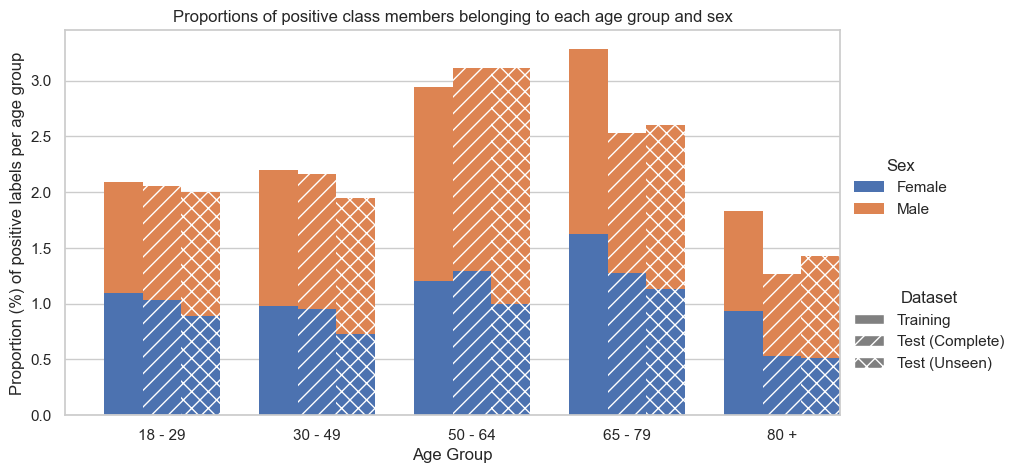

In [27]:
def agesex_barplot(save=None):
    fig, ax = plt.subplots(1,1, figsize=(10, 5))
    dfs = {
        'Training': sci_train,
        'Test (Complete)': sci_test,
        'Test (Unseen)': sci_test.loc[unseen_idx]
    }
    for name, df in dfs.items():
        df = df[['AgeBand', 'Female', 'CriticalEvent']].copy()
        series = df.Female.copy()
        df.loc[series, 'Female'] = 'Female'
        df.loc[~series, 'Female'] = 'Male'
        df.loc[df.AgeBand == '17 - 29', 'AgeBand'] = '18 - 29'
        df = df.groupby(['AgeBand', 'Female']).CriticalEvent.sum()/df.groupby(['AgeBand']).CriticalEvent.count()*100
        df = df.drop('16 and Under', level=0).reset_index().pivot(columns=['Female'], values=['CriticalEvent'], index='AgeBand').CriticalEvent
        dfs[name] = df
    plot_clustered_stacked(list(dfs.values()), list(dfs.keys()), ['Sex', 'Dataset'], title='Proportions of positive class members belonging to each age group and sex')
    ax.set_xlabel('Age Group')
    ax.set_ylabel('Proportion (%) of positive labels per age group')
    if save:
        plt.savefig(save, bbox_inches="tight", format='svg')

    

agesex_barplot(save=f'{Notebook.IMAGE_DIR}/age_sex_bars.svg')

In [142]:
scii.AandEPresentingComplaint.value_counts().sum()/scii.shape[0]

0.8792892663021031

## NEWS

In [7]:
news_performance_thresholds = {n: get_metrics(
        sci_test.derive_critical_event(within=t, return_series=True),
        sci_test.NEWS_score >= 7,
        sci_test.NEWS_score
    ) for t, n in [(1, '24h'), (2, '48h'), (999, 'Any')]}
baseline_news_performance = news_performance_thresholds['24h']

In [45]:
functions = {
    'Critical Event': sci_test.derive_critical_event,
    'Mortality':sci_test.derive_death_within,
    'Critical Care': sci_test.derive_critical_care,
}
thresholds = {
    '24h': 1,
    '48h': 2,
    'Any': 999
}

news_performances = [
    (outcome_name, threshold_name, get_metrics(
        function(within=threshold, return_series=True),
        sci_test.NEWS_score >= 7,
        sci_test.NEWS_score
    )) for (outcome_name, function) in functions.items() for (threshold_name, threshold) in thresholds.items()
]
pd.DataFrame([dict(
    Outcome=o,
    Threshold=t,
    AUC=f"{v['AUC']:.2f} ({v['AUC_Lower']:.2f}-{v['AUC_Upper']:.2f})",
    AP=f"{v['AP']:.2f} ({v['AP_Lower']:.2f}-{v['AP_Upper']:.2f})",
) for o, t, v in news_performances])

,Outcome,Threshold,AUC,AP
0,Critical Event,24h,0.80 (0.78-0.82),0.15 (0.13-0.17)
1,Critical Event,48h,0.82 (0.80-0.83),0.23 (0.20-0.25)
2,Critical Event,Any,0.76 (0.76-0.78),0.30 (0.28-0.32)
3,Mortality,24h,0.93 (0.90-0.96),0.17 (0.13-0.23)
4,Mortality,48h,0.92 (0.89-0.94),0.26 (0.21-0.31)
5,Mortality,Any,0.77 (0.76-0.78),0.23 (0.22-0.26)
6,Critical Care,24h,0.78 (0.76-0.80),0.09 (0.08-0.10)
7,Critical Care,48h,0.79 (0.77-0.80),0.11 (0.10-0.13)
8,Critical Care,Any,0.76 (0.75-0.77),0.11 (0.10-0.13)


## Metrics

In [21]:
METRICS, Y_PREDS = load_results(Notebook.SYS_RESULTS_DIR)
Y_PREDS = Y_PREDS.dropna()

In [10]:

met, ypr = load_results('models/sys_select_long')
METRICS[METRICS.estimator=='LinearSVM'] = met[met.estimator=='LinearSVM']
Y_PREDS[met[met.estimator=='LinearSVM'].name] = ypr[met[met.estimator=='LinearSVM'].name]

In [18]:
from scipy import stats as st
from sklearn.metrics import roc_auc_score, average_precision_score
def bootstrap_difference(y_true, y_score, y_idx, metric, n_resamples=99):
    diff = lambda yt, ys, idx: metric(y_true=yt, y_score=ys) - metric(y_true=yt[idx.astype(bool)], y_score=ys[idx.astype(bool)])
    center = diff(y_true, y_score, y_idx)
    res = st.bootstrap(
        data=(y_true.to_numpy(), y_score, y_idx),
        statistic=diff,
        confidence_level=0.95,
        method="percentile",
        n_resamples=n_resamples,
        vectorized=False,
        paired=True,
        random_state=42,
    )

    return res.confidence_interval.low, center, res.confidence_interval.high

def calculate_metric_diff(y_true, y_preds, y_idx, metrics):
    r = []
    for _ in metrics.to_dict(orient='records'):
        ap_low, ap, ap_up = bootstrap_difference(y_true, y_preds[_['name']], y_idx, average_precision_score)
        auc_low, auc, auc_up = bootstrap_difference(y_true, y_preds[_['name']], y_idx, roc_auc_score)
        r.append(_|dict(
            AP = ap,
            AP_Lower = ap_low,
            AP_Upper = ap_up,
            AUC = auc,
            AUC_Lower = auc_low,
            AUC_Upper = auc_up
        ))

    return pd.DataFrame(r)


In [84]:
METRICS.AP.max()-baseline_news_performance['AP']

0.37500815630655865

In [19]:
def recalc_metrics(y_idx, y_true, y_preds, metrics):
    y_true, y_preds = y_true.loc[y_idx], y_preds.loc[y_idx]
    return pd.DataFrame((
        _|get_metrics(y_true, y_preds[_['name']]>0.1, y_preds[_['name']])
        for _ in metrics.to_dict(orient='records')
    ))

# METRICS_UNSEEN, UNSEEN_METRIC_DIFF = (
#     recalc_metrics(unseen_idx, sci_test.derive_critical_event(within=1, return_series=True), Y_PREDS, METRICS),
#     calculate_metric_diff(sci_test.derive_critical_event(within=1, return_series=True), Y_PREDS, ~sci_test.PatientNumber.isin(sci_train.PatientNumber), METRICS)
# )

In [20]:
# with open(f'{Notebook.SYS_RESULTS_DIR}/metrics_unseen.bin', 'wb') as file:
#     pickle.dump((METRICS_UNSEEN, UNSEEN_METRIC_DIFF), file)

with open(f'{Notebook.SYS_RESULTS_DIR}/metrics_unseen.bin', 'rb') as file:
    METRICS_UNSEEN, UNSEEN_METRIC_DIFF = pickle.load(file)

In [33]:
UNSEEN_METRIC_DIFF.AUC.median()

-0.012252419814804905

In [34]:
UNSEEN_METRIC_DIFF.AP.median()

-0.05405689308414498

### Tables

In [53]:
def summary_metrics_tables(metrics, estimators=['LightGBM', 'L2Regression']):
    df = metrics[
        (metrics.estimator.isin(estimators)) & 
        (metrics.features.isin(select_feature_groups.keys())) & 
        (metrics.resampler == 'None')
    ]
    #df = METRICS.loc[METRICS[METRICS.estimator.isin(['LightGBM', 'L1Regression', 'LinearSVM']) & METRICS.features.isin(select_feature_groups.keys())].groupby(['estimator', 'features']).AUC.idxmax()]

    for estimator in ['LightGBM', 'L2Regression'] :
        display(pd.DataFrame([dict(
            Estimator=_['estimator'],
            Features=select_feature_groups[_['features']],
            AUC=f"{_['AUC']:.2f} ({_['AUC_Lower']:.2f}-{_['AUC_Upper']:.2f})",
            AP=f"{_['AP']:.2f} ({_['AP_Lower']:.2f}-{_['AP_Upper']:.2f})"
        ) for _ in df[df.estimator==estimator].to_dict(orient='records')]))

summary_metrics_tables(METRICS)

,Estimator,Features,AUC,AP
0,LightGBM,Vitals,0.83 (0.82-0.85),0.18 (0.16-0.21)
1,LightGBM,& Obs,0.87 (0.85-0.88),0.31 (0.28-0.35)
2,LightGBM,& Labs,0.89 (0.88-0.90),0.31 (0.28-0.35)
3,LightGBM,& Notes,0.89 (0.88-0.90),0.32 (0.29-0.36)
4,LightGBM,& Services,0.92 (0.91-0.93),0.51 (0.48-0.55)


,Estimator,Features,AUC,AP
0,L2Regression,Vitals,0.81 (0.80-0.83),0.16 (0.13-0.18)
1,L2Regression,& Obs,0.84 (0.82-0.85),0.26 (0.23-0.29)
2,L2Regression,& Labs,0.84 (0.82-0.85),0.26 (0.23-0.29)
3,L2Regression,& Notes,0.85 (0.84-0.87),0.26 (0.23-0.29)
4,L2Regression,& Services,0.89 (0.88-0.91),0.47 (0.43-0.50)


In [22]:
def summary_metrics_unseen_comparison(metrics, metrics_unseen, estimators=['LightGBM', 'L2Regression']):
    mask = lambda df: df[
        (df.estimator.isin(estimators)) & 
        (df.features.isin(select_feature_groups.keys())) & 
        (df.resampler == 'None')
    ]
    dfs = [('Complete', metrics), ('Unseen', metrics_unseen)]
    df = pd.DataFrame((dict(
            Metric=metric,
            Estimator=pretty_print_models[_['estimator']],
            Features=select_feature_groups[_['features']],
            #Value=f"{_[metric]:.2f} ({_[metric+'_Lower']:.2f}-{_[metric+'_Upper']:.2f})",
            Value=f"{_[metric]:.3f}",
            Dataset=dataset,
        )) for dataset, df in dfs for metric in ('AUC', 'AP') for _ in mask(df).to_dict(orient='records')
    ).sort_values(['Metric', 'Estimator', 'Dataset']).set_index(['Metric', 'Estimator', 'Dataset', 'Features']).unstack()['Value'][select_feature_groups.values()]
    df.columns = list(df.columns)
    return df


summary = summary_metrics_unseen_comparison(METRICS, METRICS_UNSEEN)
summary
#

Vitals  & Obs & Labs & Notes & Services
Metric Estimator Dataset                                         
AP     LR-L2     Complete  0.157  0.258  0.259   0.264      0.466
                 Unseen    0.172  0.309  0.305   0.312      0.478
       LightGBM  Complete  0.179  0.314  0.314   0.323      0.513
                 Unseen    0.206  0.370  0.365   0.374      0.523
AUC    LR-L2     Complete  0.812  0.836  0.838   0.851      0.894
                 Unseen    0.823  0.843  0.845   0.854      0.896
       LightGBM  Complete  0.835  0.868  0.888   0.891      0.922
                 Unseen    0.842  0.879  0.896   0.897      0.923

In [145]:
print(summary.to_latex(bold_rows=True, escape=False, column_format='lll|ccccc', multirow=True, formatters=[lambda x: f'${x}$' for _ in range(5)]))

\begin{tabular}{lll|ccccc}
\toprule
    &          &        &   Vitals &    & Obs &   & Labs &  & Notes & & Services \\
\textbf{Metric} & \textbf{Estimator} & \textbf{Dataset} &          &          &          &          &            \\
\midrule
\multirow{4}{*}{\textbf{AP}} & \multirow{2}{*}{\textbf{LR-L2}} & \textbf{Complete} &  $0.157$ &  $0.258$ &  $0.259$ &  $0.264$ &    $0.466$ \\
    &          & \textbf{Unseen} &  $0.172$ &  $0.309$ &  $0.305$ &  $0.312$ &    $0.478$ \\
\cline{2-8}
    & \multirow{2}{*}{\textbf{LightGBM}} & \textbf{Complete} &  $0.179$ &  $0.314$ &  $0.314$ &  $0.323$ &    $0.513$ \\
    &          & \textbf{Unseen} &  $0.206$ &  $0.370$ &  $0.365$ &  $0.374$ &    $0.523$ \\
\cline{1-8}
\cline{2-8}
\multirow{4}{*}{\textbf{AUC}} & \multirow{2}{*}{\textbf{LR-L2}} & \textbf{Complete} &  $0.812$ &  $0.836$ &  $0.838$ &  $0.851$ &    $0.894$ \\
    &          & \textbf{Unseen} &  $0.823$ &  $0.843$ &  $0.845$ &  $0.854$ &    $0.896$ \\
\cline{2-8}
    & \multirow{2}{*

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.


In [56]:
def news_summary_metrics():
    y_test = sci_test.derive_critical_event(within=1, return_series=True)
    metrics = [get_metrics(
        y_test,
        sci_test.NEWS_score >= 7,
        sci_test.NEWS_score
    ), get_metrics(
        y_test.loc[unseen_idx],
        sci_test.loc[unseen_idx].NEWS_score >= 7,
        sci_test.loc[unseen_idx].NEWS_score
    )]
    metrics = [_|dict(
        name='NEWS2',
        estimator='NEWS2',
        resampler=None,
        features='NEWS2',
        outcome_within=1
    ) for _ in metrics]
    metrics_diff = calculate_metric_diff(y_test, {'NEWS2': sci_test.NEWS_score}, ~sci_test.PatientNumber.isin(sci_train.PatientNumber), pd.DataFrame(metrics[0], index=[0])).to_dict(orient='records')[0]

    dfs = {'Test (Complete)': metrics[0], 'Test (Unseen)': metrics[1], 'Delta': metrics_diff}
    r = [dict(
        Data=dfname,
        Metric=metric,
        Estimator=_['estimator'],
        Features=_['features'],
        Summary=f'{_[metric]:.5f} ({_[metric+"_Lower"]:.5f}-{_[metric + "_Upper"]:.5f})',
    ) for dfname, _ in dfs.items() for metric in ('AUC', 'AP')]
    return r

In [147]:
def summary_metrics_unseen_comparison(metrics, metrics_unseen, metrics_diff):
    dfs = {'Test (Complete)': metrics, 'Test (Unseen)': metrics_unseen, 'Delta': metrics_diff}
    dfs = {k: v[(v.resampler=='None')&(v.features.isin(select_feature_groups.keys()))] for k, v in dfs.items()}
    group_names = select_feature_groups | select_scored_feature_groups
    r = [dict(
        Data=dfname,
        Metric=metric,
        Estimator=pretty_print_models[_['estimator']],
        Features=group_names[_['features']],
        Summary=f'{_[metric]:.5f} ({_[metric+"_Lower"]:.5f}-{_[metric + "_Upper"]:.5f})',
    ) for dfname, df in dfs.items() for _ in df.to_dict(orient='records') for metric in ('AUC', 'AP')]
    r = news_summary_metrics() + r
    return pd.DataFrame(r).pivot(index=['Features', 'Estimator'], columns=['Metric', 'Data'], values='Summary').loc[['NEWS2', 'Vitals', '& Obs', '& Labs', '& Notes', '& Services']][['AUC', 'AP']]

r = summary_metrics_unseen_comparison(METRICS, METRICS_UNSEEN, UNSEEN_METRIC_DIFF)#.set_index(['Estimator', 'Features', 'Metric', 'Data', 'Resampler'])
r

Metric                                      AUC                             \
Data                            Test (Complete)              Test (Unseen)   
Features   Estimator                                                         
NEWS2      NEWS2      0.79837 (0.78178-0.81774)  0.81211 (0.78853-0.83516)   
Vitals     LR         0.81202 (0.79589-0.82812)  0.82302 (0.80074-0.84682)   
           LR-EN      0.81084 (0.79487-0.82711)  0.82240 (0.79999-0.84633)   
           LR-L1      0.81202 (0.79587-0.82817)  0.82300 (0.80067-0.84684)   
           LR-L2      0.81204 (0.79593-0.82814)  0.82302 (0.80070-0.84683)   
           LightGBM   0.83451 (0.81795-0.84949)  0.84203 (0.82264-0.86360)   
           LinearSVM  0.80991 (0.79308-0.82680)  0.81609 (0.79223-0.84143)   
           XGBoost    0.83810 (0.82243-0.85295)  0.84792 (0.83019-0.86909)   
& Obs      LR         0.83622 (0.82009-0.85170)  0.84324 (0.82577-0.86259)   
           LR-EN      0.83645 (0.82043-0.85198)  0.84346 (0.82612-0.86266)   
           LR-L1      0.83633 (0.82028-0.85191)  0.84337 (0.82579-0.86271)   
           LR-L2      0.83621 (0.82002-0.85168)  0.84324 (0.82580-0.86251)   
           LightGBM   0.86770 (0.85390-0.88193)  0.87881 (0.86276-0.89762)   
           LinearSVM  0.81734 (0.80009-0.83362)  0.80908 (0.78420-0.83397)   
           XGBoost    0.86855 (0.85494-0.88231)  0.87920 (0.86105-0.89896)   
& Labs     LR         0.83829 (0.82257-0.85332)  0.84489 (0.82329-0.86387)   
           LR-EN      0.83848 (0.82249-0.85357)  0.84495 (0.82355-0.86405)   
           LR-L1      0.84601 (0.83053-0.86145)  0.85271 (0.83039-0.87151)   
           LR-L2      0.83826 (0.82263-0.85332)  0.84484 (0.82330-0.86376)   
           LightGBM   0.88789 (0.87566-0.90086)  0.89579 (0.87922-0.91310)   
           LinearSVM  0.81036 (0.79234-0.82745)  0.80485 (0.78289-0.82659)   
           XGBoost    0.88099 (0.86808-0.89400)  0.88979 (0.87112-0.90633)   
& Notes    LR         0.84874 (0.83381-0.86303)  0.85299 (0.83578-0.87141)   
           LR-EN      0.85112 (0.83649-0.86548)  0.85363 (0.83651-0.87210)   
           LR-L1      0.85621 (0.84200-0.87038)  0.85986 (0.84446-0.87751)   
           LR-L2      0.85086 (0.83647-0.86516)  0.85360 (0.83637-0.87172)   
           LightGBM   0.89065 (0.87932-0.90209)  0.89731 (0.88408-0.91332)   
           LinearSVM  0.81852 (0.80439-0.83384)  0.83075 (0.81248-0.85447)   
           XGBoost    0.88454 (0.87280-0.89649)  0.89101 (0.87656-0.90610)   
& Services LR         0.89144 (0.87930-0.90370)  0.89280 (0.87805-0.90846)   
           LR-EN      0.89407 (0.88197-0.90623)  0.89555 (0.88032-0.91168)   
           LR-L1      0.89551 (0.88354-0.90677)  0.89778 (0.88336-0.91315)   
           LR-L2      0.89436 (0.88216-0.90637)  0.89591 (0.88078-0.91169)   
           LightGBM   0.92208 (0.91150-0.93140)  0.92295 (0.91214-0.93775)   
           LinearSVM  0.86435 (0.84973-0.87873)  0.85779 (0.84106-0.87776)   
           XGBoost    0.91272 (0.90224-0.92283)  0.91374 (0.90198-0.92932)   

Metric                                                                     AP  \
Data                                         Delta            Test (Complete)   
Features   Estimator                                                            
NEWS2      NEWS2      -0.01374 (-0.02892--0.00001)  0.14620 (0.12840-0.16843)   
Vitals     LR          -0.01375 (-0.02613-0.00152)  0.15654 (0.13472-0.18050)   
           LR-EN       -0.01433 (-0.02630-0.00110)  0.15472 (0.13326-0.17813)   
           LR-L1       -0.01371 (-0.02613-0.00152)  0.15637 (0.13463-0.18024)   
           LR-L2       -0.01373 (-0.02611-0.00153)  0.15654 (0.13472-0.18066)   
           LightGBM    -0.01110 (-0.02066-0.00401)  0.17902 (0.15677-0.20542)   
           LinearSVM   -0.01150 (-0.02470-0.00489)  0.15484 (0.13396-0.17888)   
           XGBoost    -0.01432 (-0.02323--0.00065)  0.17117 (0.15002-0.19579)   
& Obs      LR          -0.01140 (-0.02059-0.00670)  0.25813 (0.228

In [149]:
print(r['AUC'].to_latex(bold_rows=True, multirow=True, multicolumn=True, longtable=False, column_format='llrrrrrr'))

\begin{tabular}{llrrrrrr}
\toprule
           & \textbf{Data} &            Test (Complete) &              Test (Unseen) &                         Delta \\
\textbf{Features} & \textbf{Estimator} &                            &                            &                               \\
\midrule
\textbf{NEWS2} & \textbf{NEWS2} &  0.79837 (0.78178-0.81774) &  0.81211 (0.78853-0.83516) &  -0.01374 (-0.02892--0.00001) \\
\multirow{7}{*}{\textbf{Vitals}} & \textbf{LR} &  0.81202 (0.79589-0.82812) &  0.82302 (0.80074-0.84682) &   -0.01375 (-0.02613-0.00152) \\
           & \textbf{LR-EN} &  0.81084 (0.79487-0.82711) &  0.82240 (0.79999-0.84633) &   -0.01433 (-0.02630-0.00110) \\
           & \textbf{LR-L1} &  0.81202 (0.79587-0.82817) &  0.82300 (0.80067-0.84684) &   -0.01371 (-0.02613-0.00152) \\
           & \textbf{LR-L2} &  0.81204 (0.79593-0.82814) &  0.82302 (0.80070-0.84683) &   -0.01373 (-0.02611-0.00153) \\
           & \textbf{LightGBM} &  0.83451 (0.81795-0.84949) &  0.84203 (0.82

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.


### Bar Plots

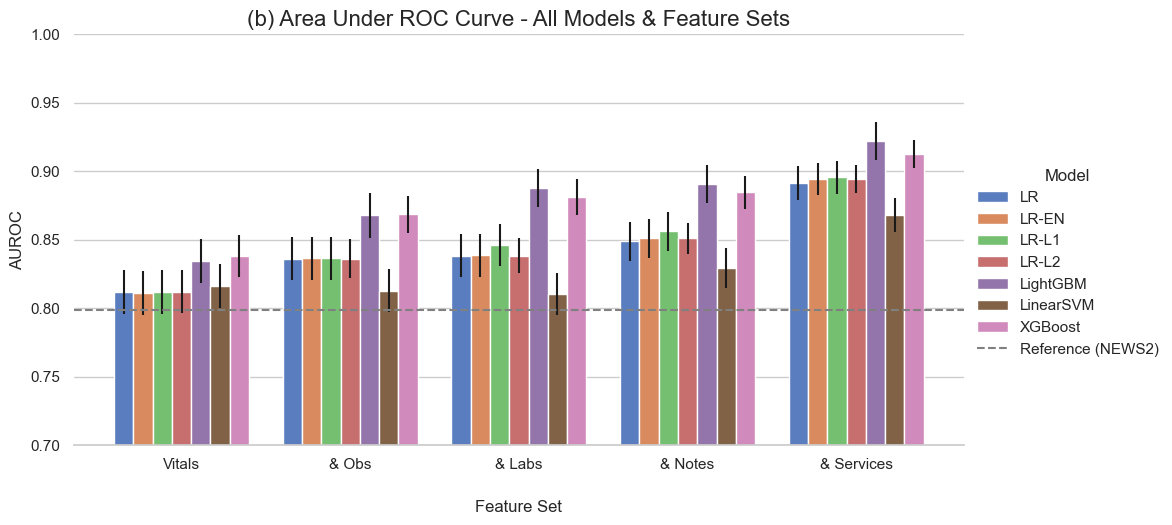

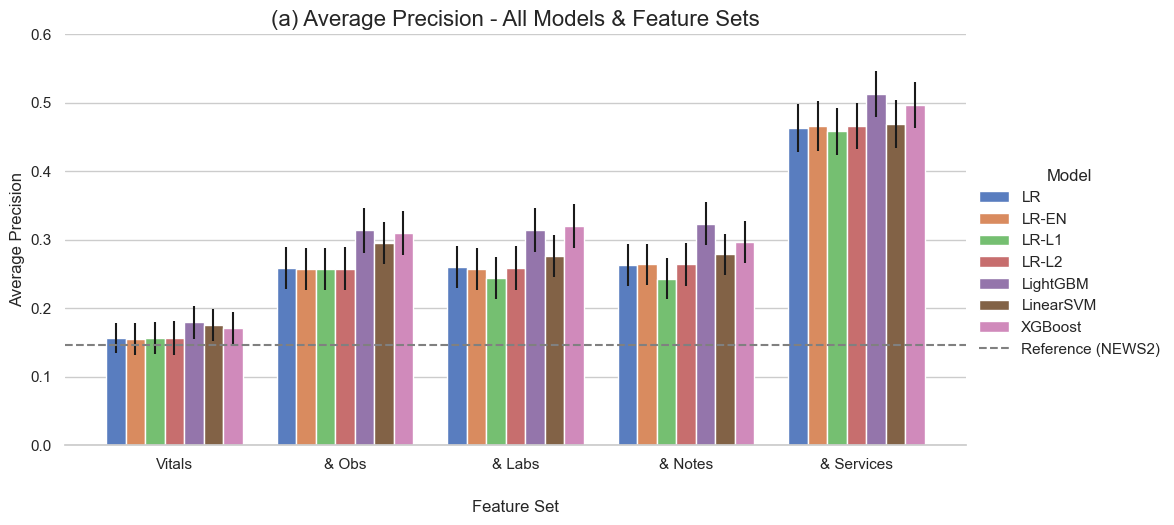

In [85]:
def select_feature_ablation_barplot(metrics, feature_groups, metric='AUC', ylim=(0.0, 1.0), ylabel=None, baseline=None, title=None, save=None):
    sns.set_style('whitegrid')
    df = metrics[
        (metrics.features.isin(feature_groups.keys()))
        & (metrics.resampler == 'None')
    ].rename(columns=dict(
        features='Features',
        estimator='Model'
    ))
    err = (df[f'{metric}_Upper']-df[f'{metric}_Lower'])/2
    df['Features'] = pd.Categorical(df.Features.replace(feature_groups), ordered=True, categories=feature_groups.values())
    df['Model'] = df.Model.replace(pretty_print_models)
    g = sns.catplot(
        data=df.sort_values(['Model','Features']), x='Features', y=metric, hue='Model',
        kind='bar', palette='muted', height=6, orient='v', legend=False
    )
    g.despine(left=True)
    g.fig.set_size_inches(10,5)
    g.ax.set_ylim(ylim)
    x_coords = [p.get_x() + 0.5*p.get_width() for p in g.ax.patches]
    y_coords = [p.get_height() for p in g.ax.patches]
    g.ax.errorbar(x=x_coords, y=y_coords, yerr=err, fmt="none", c= "k")

    if baseline is not None:
        g.refline(y = baseline[metric], color = 'gray', linestyle = '--', label = "Reference (NEWS2)") 
        g.add_legend(title='Model')
    
    g.set_xlabels("Feature Set", labelpad=20)
    g.ax.set_title(title, fontsize=16)
    if ylabel:
        g.set_ylabels(ylabel)
    if metric=='AUC':
        g.set_ylabels('AUROC')
    if save:
        plt.savefig(save, bbox_inches="tight", format='svg')

select_feature_ablation_barplot(METRICS, select_feature_groups, 'AUC', (0.7, 1.0), baseline=baseline_news_performance, ylabel='AUC', title='(b) Area Under ROC Curve - All Models & Feature Sets', save=f'{Notebook.IMAGE_DIR}/auc_bar.svg')
select_feature_ablation_barplot(METRICS, select_feature_groups, 'AP', (0.0, 0.6), baseline=baseline_news_performance, ylabel='Average Precision', title='(a) Average Precision - All Models & Feature Sets', save=f'{Notebook.IMAGE_DIR}/ap_bar.svg')

### Precision-Recall

In [14]:
test_set_n_days = (
    sci.loc[sci_test.index].AdmissionDateTime.max()
    - sci.loc[sci_test.index].AdmissionDateTime.min()
).days

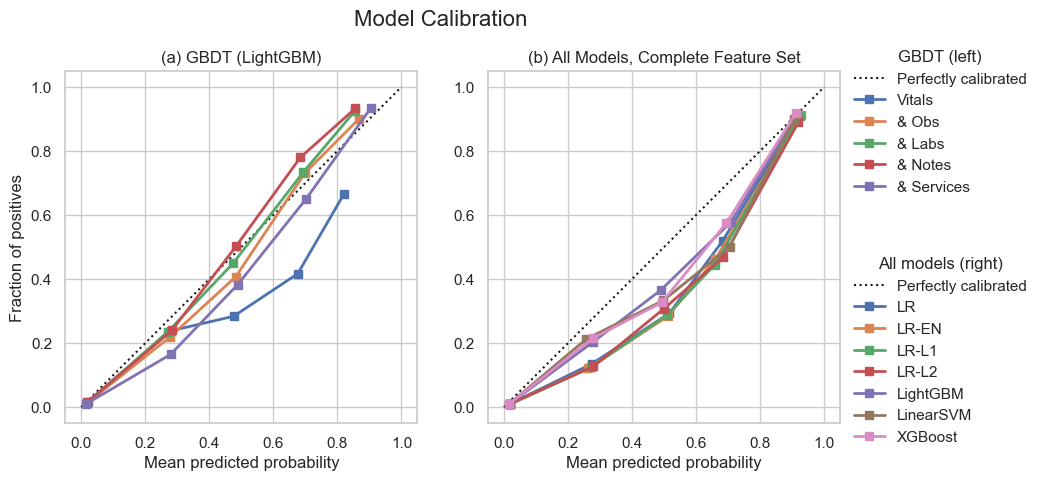

In [24]:
def model_preds_across_features(metrics, y_preds, estimator='LightGBM'):
    metrics_l = metrics[(metrics.estimator == estimator) & (metrics.features.isin(select_feature_groups.keys())) & (metrics.resampler == 'None') & (metrics.outcome_within == 1)]
    y_preds_l = y_preds[metrics_l.name]
    y_preds_l.columns=metrics_l.features.replace(select_feature_groups)
    y_preds_l = y_preds_l.to_dict(orient='list')

    return y_preds_l

def all_model_preds(metrics, y_preds, features='with_notes_labs_and_hospital'):
    metrics_r = metrics.loc[
        metrics[(metrics.features==features) & (metrics.outcome_within==1)].groupby('estimator').AP.idxmax()
    ]

    y_preds_r = y_preds[metrics_r.name]
    y_preds_r.columns=metrics_r.estimator
    y_preds_r.columns = y_preds_r.columns.map(pretty_print_models)
    y_preds_r = y_preds_r[sorted(y_preds_r.columns)]
    y_preds_r = y_preds_r.to_dict(orient='list')

    return y_preds_r

def calib_curves(metrics, y_preds, save=None):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    sns.set_style("whitegrid")
    for _ in ax:
        _.set_box_aspect(1)
    
    y_test = sci_test.derive_critical_event(within=1, return_series=True).loc[y_preds.index]
    y_preds_l, y_preds_r = model_preds_across_features(metrics, y_preds, 'XGBoost'), all_model_preds(metrics, y_preds)

    plot_calibration_curves(y_test, y_preds_l, ax=ax[0], title='(a) GBDT (LightGBM)')
    plot_calibration_curves(y_test, y_preds_r, ax=ax[1], title='(b) All Models, Complete Feature Set')

    sns.move_legend(ax[0], "upper left", bbox_to_anchor=(2.2, 1.1), frameon=False, title='GBDT (left)')
    sns.move_legend(ax[1], "lower left", bbox_to_anchor=(1, -0.1), frameon=False, title='All models (right)')
    ax[1].set_ylabel(None)
   # fig.tight_layout(h_pad=0.5, w_pad=0.5)
    fig.subplots_adjust(top=0.9)
    fig.suptitle('Model Calibration')
    if save:
        plt.savefig(save, bbox_inches='tight', format='svg')
   

calib_curves(METRICS, Y_PREDS, save=f'{Notebook.IMAGE_DIR}/calib_curves.svg')

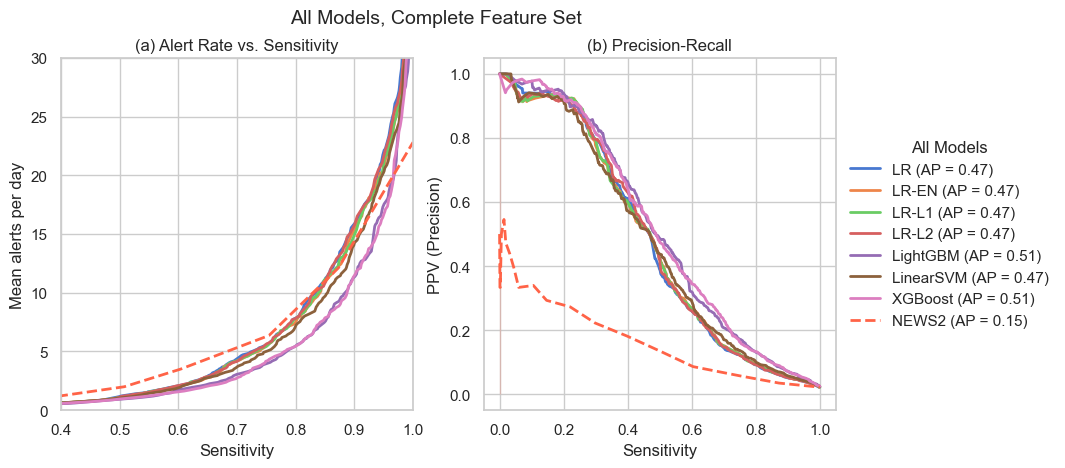

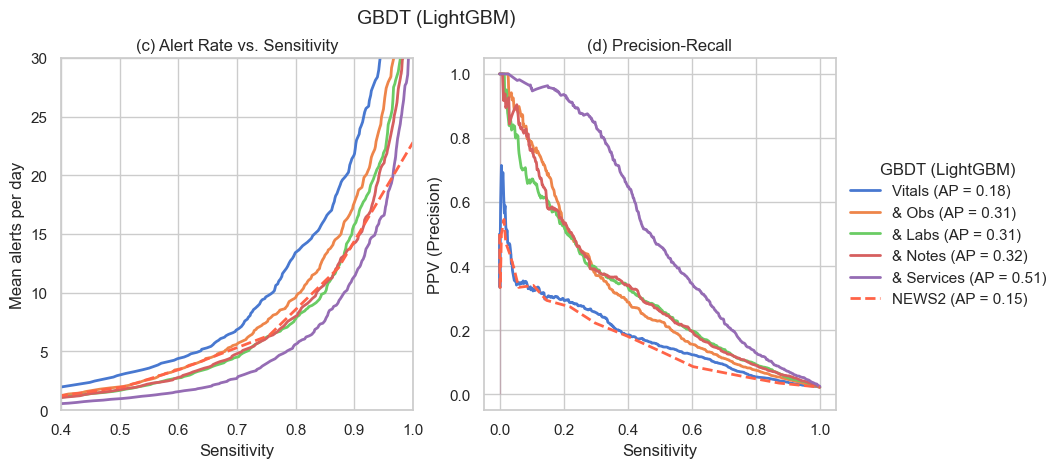

In [16]:
def pr_alert_curves(metrics, y_preds, data_function=model_preds_across_features, title='GBDT (LightGBM)', legend='GBDT (LightGBM)', save=None, debug=False, subtitles=['Alert Rate vs. Sensitivity', 'Precision-Recall']):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    sns.set_style("whitegrid")
    for _ in ax:
        _.set_box_aspect(1)
    
    if debug:
        y_preds = y_preds.sample(1000)

    y_preds_l = data_function(metrics, y_preds)
    y_test = sci_test.derive_critical_event(within=1, return_series=True).loc[y_preds.index]
    baseline_news = {'NEWS2': sci_test.loc[y_test.index, 'NEWS_score']}
    
    with sns.color_palette('muted'):
        plot_pr_curves(y_test, y_preds_l | baseline_news, smoothing=(not debug), ax=ax[1], palette=sns.color_palette('muted'), baseline_key='NEWS2', title=subtitles[1])
        plot_alert_rate(y_test, y_preds_l | baseline_news, test_set_n_days, ax=ax[0], intercepts=False, baseline_key='NEWS2', title=subtitles[0], xlim=(0.4, 1.0), ylim=(0, 30))

        
    sns.move_legend(ax[1], "center left", bbox_to_anchor=(1, 0.5), frameon=False, title=legend)
    ax[0].legend([], [], frameon=False)
    
    fig.subplots_adjust(top=0.95)
    fig.suptitle(title, fontsize=14)
    if save:
        plt.savefig(save, bbox_inches='tight', format='svg')

pr_alert_curves(
    METRICS, Y_PREDS, all_model_preds, 
    title='All Models, Complete Feature Set', legend='All Models', 
    subtitles=['(a) Alert Rate vs. Sensitivity', '(b) Precision-Recall'],
    save=f'{Notebook.IMAGE_DIR}/alert_pr_all.svg'
)
pr_alert_curves(
    METRICS, Y_PREDS, model_preds_across_features, 
    title='GBDT (LightGBM)', legend='GBDT (LightGBM)', 
    subtitles=['(c) Alert Rate vs. Sensitivity', '(d) Precision-Recall'],
    save=f'{Notebook.IMAGE_DIR}/alert_pr_lightgbm.svg'
)

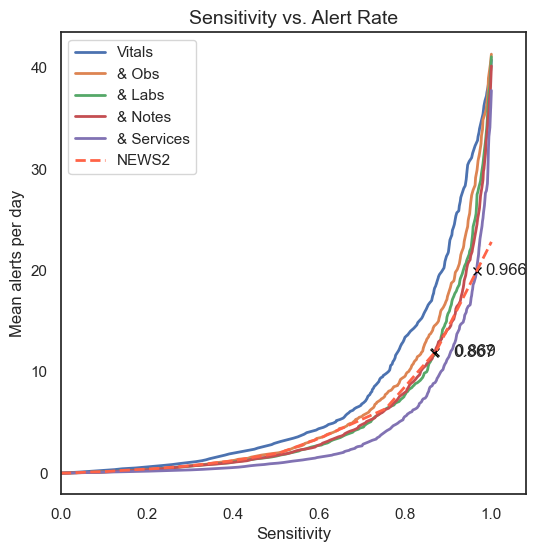

In [17]:
y_test = sci_test.derive_critical_event(within=1, return_series=True).loc[Y_PREDS.index]
baseline_news = {'NEWS2': sci_test.loc[y_test.index, 'NEWS_score']}
plot_alert_rate(y_test, model_preds_across_features(METRICS, Y_PREDS) | baseline_news, test_set_n_days, intercepts=True, baseline_key='NEWS2')

In [21]:
y_test = sci_test.derive_critical_event(within=1, return_series=True).loc[Y_PREDS.index]
baseline_news = {'NEWS2': sci_test.loc[y_test.index, 'NEWS_score']}
sensitivity, news_rate, lgbm_rate = biggest_alert_rate_diff(
    sci_test.derive_critical_event(return_series=True, within=1),
    baseline_news['NEWS2'],
    Y_PREDS["LightGBM_None_Within-1_with_notes_labs_and_hospital"],
    test_set_n_days,
)
print(
    f"At sensitivity ~{sensitivity:.3f}: NEWS Alert rate: {news_rate:.3f}, LGBM Alert rate: {lgbm_rate:.3f} -> {100-(lgbm_rate*100/news_rate):.3f}% less"
)

At sensitivity ~0.864: NEWS Alert rate: 12.110, LGBM Alert rate: 9.869 -> 18.503% less


## Sub-scores

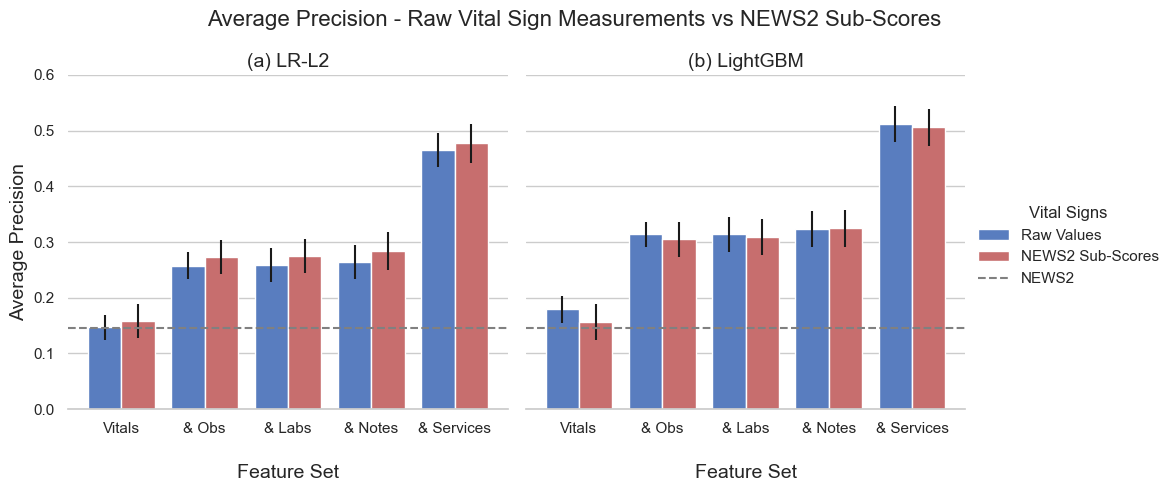

In [147]:
def subscores_barplot(metrics, feature_groups, scored_feature_groups, metric='AP', ylim=(0.0, 0.6), baseline=None, save=None):
    df = metrics[(metrics.estimator.isin(['LightGBM', 'L2Regression'])) & (metrics.resampler=='None')].copy()
    
    df['Vital Signs'] = df['features'].isin(scored_feature_groups.keys()).map({
        True:'NEWS2 Sub-Scores',
        False:'Raw Values'
    })
    df.loc[(df.estimator == 'L2Regression')&(df.features=='news'), metric] -= 0.010
    df.loc[(df.estimator == 'LightGBM')&(df.features.isin(scored_feature_groups.keys()))&~(df.features.isin(['news_scores', 'scores_with_notes_labs_and_hospital'])), metric] -= 0.01
    df['features'] = df.features.map(feature_groups | scored_feature_groups)
    err = (df[f'{metric}_Upper']-df[f'{metric}_Lower'])/2
    df = df.rename(columns=dict(
        features='Features',
        estimator='Model',
    ))
    df['Model'] = df.Model.replace(dict(
        L2Regression='(a) LR-L2',
        LightGBM = '(b) LightGBM'
    ))

    sns.set_style('whitegrid')

    g = sns.catplot(
        data=df, x='Features', y=metric, hue='Vital Signs', col='Model',
        kind='bar', palette=[sns.color_palette('muted')[0], sns.color_palette('muted')[3]], height=6, orient='v', legend=False, 
    )
    g.despine(left=True)
    g.fig.set_size_inches(10,5)
    subp = [(i, model, ax) for i, (model, ax) in enumerate(g.axes_dict.items())]
    for i, model, ax in subp:
        ax.set_ylim(ylim)
        x_coords = [p.get_x() + 0.5*p.get_width() for p in ax.patches]
        y_coords = [p.get_height() for p in ax.patches]
        ax.errorbar(x=x_coords, y=y_coords, yerr=err[(df.Model==model)], fmt="none", c= "k")
    g.set_xlabels("Feature Set", labelpad=20, fontsize=14)
    g.set_ylabels('Average Precision', fontsize=14)
    if baseline is not None:
        g.refline(y = baseline[metric], color = 'gray', linestyle = '--', label = "NEWS2") 
        g.add_legend(title='Vital Signs')
    
    g.set_titles(template='{col_name}', size=14)
    g.fig.suptitle('Average Precision - Raw Vital Sign Measurements vs NEWS2 Sub-Scores')
    g.fig.subplots_adjust(top=0.85)

    if save:
        plt.savefig(save, bbox_inches="tight", format='svg')

subscores_barplot(METRICS, select_feature_groups, select_scored_feature_groups, baseline=baseline_news_performance, save=f'{Notebook.IMAGE_DIR}/raw_vs_scored_ap.svg')


## LR Coefficients

In [68]:
from utils.evaluation import get_calibrated_regression_coefficients, regression_coefficient_sorted_barplot
def get_coefficients(name, onehot_cols=None, directory=Notebook.SYS_RESULTS_DIR):
    if onehot_cols is None:
        X_train, X_test, y_train, y_test = get_xy(scii, Estimator_L1Regression, scii.feature_group_combinations['with_notes_labs_and_hospital'])
        onehot_cols = X_train.get_onehot_categorical_columns()
    
    model, *_ = load_model(name, directory)
    coef = get_calibrated_regression_coefficients(
        model, model.feature_names_in_, name.split('_')[0]
    ).set_index('Feature').Coefficient

    cat_cols = select_categorical_cols | dict(AdmissionMethod='Admission Pathway')

    coef_num = coef[~coef.index.isin([__ for _ in onehot_cols.values() for __ in _])].sort_values()
    coef_cat = pd.DataFrame([dict(
        Feature=cat_cols[key],
        Value=_,
        Coef=coef.loc[_]    
    ) for key, val in onehot_cols.items() for _ in val if _ in coef.index])
    coef_cat.Value = coef_cat.Value.str.split('__').str[1]

    return coef_num, coef_cat

#coef_num, coef_cat = get_coefficients('L1Regression_None_Within-1_with_notes_labs_and_hospital')

In [70]:
X_train, X_test, y_train, y_test = get_xy(scii, Estimator_L1Regression, scii.feature_group_combinations['with_notes_labs_and_hospital'])
onehot_cols = X_train.get_onehot_categorical_columns()

In [71]:
def categorical_coefficient_table(onehot_cols, estimators=['LogisticRegression', 'L1Regression', 'L2Regression', 'ElasticNetRegression'], feature_group='with_notes_labs_and_hospital', directory=Notebook.SYS_RESULTS_DIR, within=1):
    r = pd.concat((
        get_coefficients(
            f'{estimator}_None_Within-{within}_{feature_group}', onehot_cols, directory=directory
        )[1].assign(Model=pretty_print_models[estimator]).replace('NAN', 'Unknown')
    ) for estimator in estimators)
    r.Value = r.Value.replace(pretty_print_categoricals)
    top = r.copy()
    top.Coef = top.Coef.apply(abs)
    top = top.groupby(['Feature', 'Value']).mean().groupby('Feature').Coef.nlargest(5).droplevel(0).index
    return r.pivot(index=['Feature', 'Value'], columns='Model', values='Coef').loc[top].round(4)

cat_coef = categorical_coefficient_table(onehot_cols)
cat_coef

Model                                           LR   LR-EN   LR-L1   LR-L2
Feature              Value                                                
A&E Diagnosis        dementia              -5.7765 -1.1784  0.0000 -0.9183
                     dizz-                 -4.5919 -0.5101  0.0000 -0.5284
                     Unknown                1.1955  0.5185  0.4662  0.6791
                     diarrh                 0.9823  0.2567  0.0000  0.4210
                     collaps-               0.8968  0.2167  0.0000  0.3797
Admission Pathway    Emg. Tran. Oth. Prov.  1.1180  1.5083  0.8563  1.6927
                     Elective Booked       -2.8855 -1.2208  0.0000 -0.8683
                     Emg. OPD              -1.7830 -1.2437  0.0000 -0.9072
                     Booked Adm.           -1.5348 -1.0707  0.0000 -0.7858
                     Emg. A&E               0.4351  0.8734  0.9080  1.1078
Admission Specialty  General Med.           6.0295  4.4717  4.5527  4.2806
                     Respiratory Med.       5.7150  4.1316  3.7710  3.8547
                     Geriatric Med.         5.1367  3.5265  2.4572  3.1878
                     Bariatric Surg.        8.3252  2.2719  0.0000  1.7883
                     Spinal Surg. Svc.     -6.1272 -2.0428  0.0000 -1.5927
Breathing Device     NHF                    3.1081  3.1803  3.0982  3.0330
                     Unknown               -5.8139 -1.2859  0.0000 -0.6555
                     A - Air               -1.4371 -1.6811 -1.3501 -0.8618
                     NIV - NIV              1.1222  1.2162  1.2235  1.1433
                     Other                  0.8460  0.9446  1.1644  0.8756
Presenting Complaint ear problems          -6.0519 -1.5286  0.0000 -1.2409
                     facial problems       -5.5940 -1.4631  0.0000 -1.1675
                     gi bleeding            2.8015  1.7446  1.3005  1.7253
                     diabetes               2.7086  1.6517  1.1506  1.6313
                     testicular pain       -4.8856 -0.9064  0.0000 -0.8156

In [72]:
print(cat_coef.to_latex(bold_rows=True, multirow=True, column_format='llrrrr'))

\begin{tabular}{llrrrr}
\toprule
                     & \textbf{Model} &      LR &   LR-EN &   LR-L1 &   LR-L2 \\
\textbf{Feature} & \textbf{Value} &         &         &         &         \\
\midrule
\multirow{5}{*}{\textbf{A\&E Diagnosis}} & \textbf{dementia} & -5.7765 & -1.1784 &  0.0000 & -0.9183 \\
                     & \textbf{dizz-} & -4.5919 & -0.5101 &  0.0000 & -0.5284 \\
                     & \textbf{Unknown} &  1.1955 &  0.5185 &  0.4662 &  0.6791 \\
                     & \textbf{diarrh} &  0.9823 &  0.2567 &  0.0000 &  0.4210 \\
                     & \textbf{collaps-} &  0.8968 &  0.2167 &  0.0000 &  0.3797 \\
\cline{1-6}
\multirow{5}{*}{\textbf{Admission Pathway}} & \textbf{Emg. Tran. Oth. Prov.} &  1.1180 &  1.5083 &  0.8563 &  1.6927 \\
                     & \textbf{Elective Booked} & -2.8855 & -1.2208 &  0.0000 & -0.8683 \\
                     & \textbf{Emg. OPD} & -1.7830 & -1.2437 &  0.0000 & -0.9072 \\
                     & \textbf{Booked Adm.} & -1.5348 & -1.

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.


In [73]:
def numerical_coefficient_table(estimators=['LogisticRegression', 'L1Regression', 'L2Regression', 'ElasticNetRegression'], feature_group='with_notes_labs_and_hospital', directory=Notebook.SYS_RESULTS_DIR, within=1):
    X_train, X_test, y_train, y_test = get_xy(scii, Estimator_L1Regression, scii.feature_group_combinations['with_notes_labs_and_hospital'])
    onehot_cols = X_train.get_onehot_categorical_columns()
    r = pd.concat((
        (
            get_coefficients(f'{_}_None_Within-{within}_{feature_group}', onehot_cols, directory=directory)[0].rename(_)
        ) for _ in estimators), axis=1
    ).round(4).T

    r.columns = map(SCICols.pretty_print_columns.get, r.columns)
    r.index = map(pretty_print_models.get, r.index)
    return r

coef = numerical_coefficient_table()
#coef.T

In [74]:
coef.T

,LR,LR-L1,LR-L2,LR-EN
Sent To SDEC,-1.0367,-1.0309,-1.0391,-1.0384
Sodium,-0.8081,-0.7383,-0.8016,-0.8073
Age,-0.5460,-0.4507,-0.5434,-0.5433
FiO2,-0.4453,-0.4357,-0.4423,-0.4440
SpO2,-0.1996,-0.1972,-0.1994,-0.1993
Creatinine,-0.1968,-0.1889,-0.1953,-0.1950
Assisted Breathing,-0.1301,-0.1242,-0.1292,-0.1288
Readmission,-0.1131,-0.0779,-0.1144,-0.1143
Temperature,-0.0525,-0.0449,-0.0517,-0.0520
Alert (AVCPU),-0.0456,-0.0183,-0.0408,-0.0413


In [75]:
print(coef.T.to_latex(bold_rows=True, column_format='lrrrr',  formatters=[lambda x: f'${x}$' for _ in range(4)], escape=False))

\begin{tabular}{lrrrr}
\toprule
{} &        LR &     LR-L1 &     LR-L2 &     LR-EN \\
\midrule
\textbf{Sent To SDEC      } & $-1.0367$ & $-1.0309$ & $-1.0391$ & $-1.0384$ \\
\textbf{Sodium            } & $-0.8081$ & $-0.7383$ & $-0.8016$ & $-0.8073$ \\
\textbf{Age               } &  $-0.546$ & $-0.4507$ & $-0.5434$ & $-0.5433$ \\
\textbf{FiO2              } & $-0.4453$ & $-0.4357$ & $-0.4423$ &  $-0.444$ \\
\textbf{SpO2              } & $-0.1996$ & $-0.1972$ & $-0.1994$ & $-0.1993$ \\
\textbf{Creatinine        } & $-0.1968$ & $-0.1889$ & $-0.1953$ &  $-0.195$ \\
\textbf{Assisted Breathing} & $-0.1301$ & $-0.1242$ & $-0.1292$ & $-0.1288$ \\
\textbf{Readmission       } & $-0.1131$ & $-0.0779$ & $-0.1144$ & $-0.1143$ \\
\textbf{Temperature       } & $-0.0525$ & $-0.0449$ & $-0.0517$ &  $-0.052$ \\
\textbf{Alert (AVCPU)     } & $-0.0456$ & $-0.0183$ & $-0.0408$ & $-0.0413$ \\
\textbf{Systolic BP       } & $-0.0205$ & $-0.0216$ & $-0.0212$ & $-0.0215$ \\
\textbf{Urea              } &  $0.00

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.


## SHAP

In [7]:
from utils.evaluation import plot_shap_features_joint, plot_calibrated_regression_coefficients

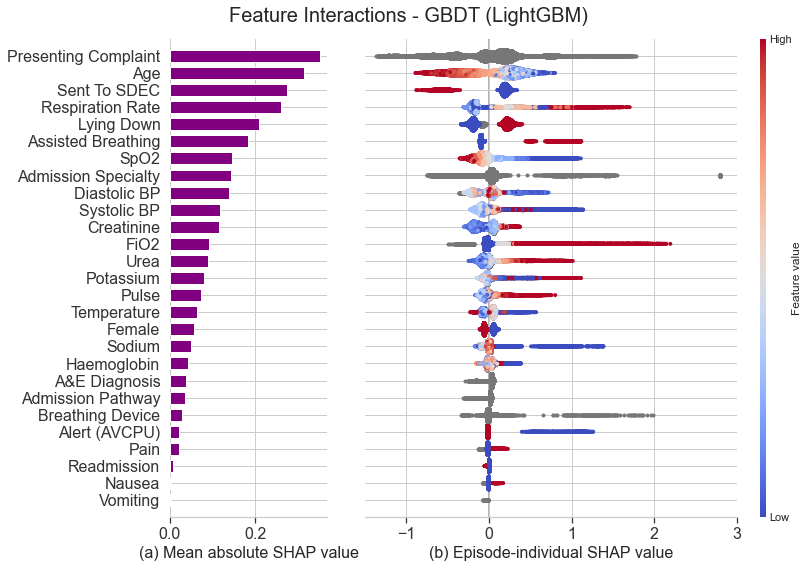

In [8]:
def lgbm_explanations(name='LightGBM_None_Within-1_with_notes_labs_and_hospital', directory=Notebook.SYS_RESULTS_DIR, save=None, title='Feature Interactions - GBDT (LightGBM)'):
    _, explanations = load_model(name, directory)
    explanations.feature_names = list(map(SCICols.pretty_print_columns.get, explanations.feature_names))
    explanations.values[explanations.values >= 2.8] = 2.8
    plot_shap_features_joint(
        explanations, 
        max_display=250,
        figsize=(12, 8),
        wspace=-0.25,
        bar_aspect=0.04,
        topadjust=0.925,
        title=title,
        save=save
    )
    
lgbm_explanations(save=f'{Notebook.IMAGE_DIR}/shap_lgbm.png')

In [7]:
def lgbm_patient(name='LightGBM_None_Within-1_with_notes_labs_and_hospital', directory=Notebook.SYS_RESULTS_DIR, patient_number=1240630):
    _, explanations = load_model(name, directory)
    explanations.feature_names = list(map(SCICols.pretty_print_columns.get, explanations.feature_names))
    explanations.values[explanations.values >= 2.8] = 2.8
    explanation = explanations[sci_test.reset_index().index[(sci_test.PatientNumber==1240630)&(sci_test.CriticalEvent==True)&(sci_test.NEWS_score < 7)][0]]
    display(sci_test[sci_test.PatientNumber==patient_number].drop([_ for _ in sci_test.columns if _.startswith("SHMI__")], axis=1))
    shap.initjs()
    return shap.plots.force(
        explanation,
        matplotlib=False,
        contribution_threshold=0.08,
        show=False,
        text_rotation=15,
    )

lgbm_patient()

,SpellSerial,PatientNumber,SEQ,Female,Age,AgeBand,Area,AdmissionDateTime,DischargeDateTime,TotalLOS,LOSBand,Over7Days,Over14Days,AdmittedAfterAEC,AdmissionMethodDescription,AssessmentAreaAdmission,AssessmentAreaDischarge,AdmissionSpecialty,LastSpecialty,AdmitWard,NextWard2,NextWard3,NextWard4,NextWard5,NextWard6,NextWard7,NextWard8,NextWard9,DischargeWard,AdmitWardLOS,NextWard2LOS,NextWard3LOS,NextWard4LOS,NextWard5LOS,NextWard6LOS,NextWard7LOS,NextWard8LOS,NextWard9LOS,DischargeWardLOS,DiedDuringStay,DiedWithin30Days,AandEPresentingComplaint,AandEArrivalTime,AandEDepartureTime,AandEPatientGroupDescription,MainOPCS4,SecOper1,SecOper2,SecOper3,SecOper4,SecOper5,SecOper6,SpellHRG,HRGDesc,PrimarySpecialtyLocalCode,CareHome,PCT,GPPractice,Haemoglobin,Urea_serum,Sodium_serum,Potassium_serum,Creatinine,NEWS_score,NewsCreatedWhen,NewsTouchedWhen,NewsAuthoredDtm,Respiration_rate,NEWS_resp_rate_score,AssistedBreathing,BreathingDevice,NEWS_device_air_score,O2_saturation,Oxygen_flow_rate,NEWS_O2_sat_score,Temperature,NEWS_temperature_score,LyingDown,SystolicBP,DiastolicBP,NEWS_BP_score,HeartRate,NEWS_heart_rate_score,AVCPU_Alert,NEWS_level_of_con_score,Pain,Nausea,VomitingSinceLastRound,ReadmissionTimespan,ReadmissionBand,Readmission,Readmitted,ReadmittedTimespan,SentToSDEC,AandEMainDiagnosis,CriticalEvent,DiedWithinThreshold,CriticalCare
99794,773828_6,1240630,1,False,53,50 - 64,M27,2019-12-02 02:50:00,2019-12-02 14:14:00,0.475000,Less than 12 Hrs,False,False,False,EMERGENCY A+E,True,True,ACUTE INTERNAL MEDICINE,ACUTE INTERNAL MEDICINE,EAU,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EAU,0.475000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.475000,False,False,NaN,2019-12-01 17:55:00,2019-12-02 02:50:00,medical,M47.9,NaN,NaN,NaN,NaN,NaN,NaN,LB15E,"Minor Bladder Procedures, 19 years and over",AIM,False,01G,P87019,121.0,3.5,143.0,4.1,87.0,3.0,2019-12-04 00:01:06,2019-12-04 00:01:06,2019-12-03 23:00:00,16.0,0.0,False,A - Air,0.0,96.0,0.000,0.0,36.8,0.0,True,132.0,78.0,0.0,79.0,0.0,False,3.0,0.0,False,False,NaT,N/A,False,True,1 days 18:20:00,False,NaN,False,False,False
55599,773828_8,1240630,2,False,53,50 - 64,M27,2019-12-03 21:10:00,2019-12-04 12:00:00,0.618055,12 - 24 Hrs,False,False,False,EMERGENCY A+E,False,False,GENERAL MEDICINE,ACUTE INTERNAL MEDICINE,HH1M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HH1M,0.618055,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.618055,False,False,overdose and poisoning,2019-12-03 15:38:00,2019-12-03 21:10:00,medical,X29.2,NaN,NaN,NaN,NaN,NaN,NaN,WH04E,"Poisoning Diagnosis without Interventions, wit...",MED,False,01G,P87019,121.0,3.5,143.0,4.1,87.0,2.0,2019-12-04 05:54:23,2019-12-04 05:54:23,2019-12-04 01:30:00,21.0,2.0,False,A - Air,0.0,96.0,0.000,0.0,36.9,0.0,True,132.0,70.0,0.0,82.0,0.0,True,0.0,0.0,False,False,1 days 18:20:00,1 Week,True,True,11 days 03:12:00,False,NaN,True,False,True
43464,773828_10,1240630,3,False,53,50 - 64,M27,2019-12-15 00:22:00,2019-12-16 17:22:00,1.708333,36 - 48 Hrs,False,False,False,EMERGENCY A+E,True,True,ACUTE INTERNAL MEDICINE,ACUTE INTERNAL MEDICINE,EAU,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EAU,1.708333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.708333,False,False,sepsis,2019-12-14 14:37:00,2019-12-14 23:59:00,medical,NaN,NaN,NaN,NaN,NaN,NaN,NaN,WH04D,"Poisoning Diagnosis without Interventions, wit...",AIM,False,01G,P87019,120.0,4.3,140.0,4.0,84.0,4.0,2019-12-16 11:20:29,2019-12-16 11:20:29,2019-12-16 11:19:00,16.0,0.0,True,N - Nasal cannula,2.0,94.0,0.162,1.0,36.5,0.0,False,112.0,80.0,0.0,98.0,1.0,True,0.0,0.0,False,False,11 days 03:12:00,1 Month,True,True,2 days 21:02:00,False,NaN,False,False,False
36096,773828_12,1240630,4,False,53,50 - 64,M27,2019-12-17 21:24:00,2019-12-20 09:20:00,2.497222,48 - 72 Hrs,False,False,False,EMERGENCY A+E,False,False,GENERAL MEDICINE,ACUTE INTERNAL MEDICINE,HH1M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,M2,1.075694,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.421528,False,False,overdose and poisoning,2019-12-17 16:07:00,2019-12-17 21:24:00,medical,X29.2,NaN,NaN,NaN,NaN,NaN,NaN,WH04D,"Poisoning Diagnosis without Interventio

In [56]:
def categorical_shap_table_lgbm():
    _, explanations, *_ = load_model('LightGBM_None_Within-1_with_notes_labs_and_hospital', Notebook.SYS_RESULTS_DIR)
    explanations.values[explanations.values > 3] = 3
    common = [_ for _ in explanations.feature_names if _ in select_categorical_cols.keys()]
    r = []
    for feature in common:
        idx = explanations.feature_names.index(feature)
        df = pd.DataFrame(
            zip(explanations[:, idx].values, explanations[:, idx].data), 
            columns=['Value', 'Data']).pivot(columns='Data').Value
        selected = df.apply(abs).mean().sort_values().tail(6).index
        r.append(df.mean().loc[selected].sort_values().rename(select_categorical_cols[feature]))
    return pd.concat([_.reset_index() for _ in r], axis=1)

categorical_shap_table_lgbm()

,Data,Breathing Device,Data,Presenting Complaint,Data,A&E Diagnosis,Data,Admission Pathway,Data,Admission Specialty
0,TM - Tracheostomy mask,0.887815,back pain,-1.147341,pain,-0.192698,EMERGENCY GP REFER,-0.210166,ACCIDENT & EMERGENCY,-0.488351
1,H40 - Humidified 40%,1.001827,facial problems,-0.954896,head,-0.165551,BOOKED ADMISSION,-0.170261,SPINAL SURGERY SERVICE,-0.425992
2,Other,1.169430,major trauma,0.936363,cope,-0.091810,EMERGENCY OPD,-0.162680,NEUROSURGERY,0.835063
3,CPAP - CPAP,1.212415,asthma,1.014811,diarrh,-0.078984,NON EM TRAN OTH PROV,-0.101525,GENERAL SURGERY,0.853884
4,NIV - NIV,1.424409,diabetes,1.456625,vomit,-0.021842,ELECTIVE PLANNED,-0.093545,UROLOGY,1.095803
5,NHF,1.636768,gi bleeding,1.484948,NaN,0.034924,EMERG TRAN OTH PROV,-0.054238,STROKE NEUROLOGY,1.368388


In [154]:
def categorical_shap_bars_lgbm():
    _, explanations, *_ = load_model('LightGBM_None_Within-1_with_notes_labs_and_hospital', Notebook.SYS_RESULTS_DIR)
    common = [_ for _ in explanations.feature_names if _ in select_categorical_cols.keys()]
    r = []
    for feature in common:
        idx = explanations.feature_names.index(feature)
        df = pd.DataFrame(
            zip(explanations[:, idx].values, explanations[:, idx].data), 
            columns=['Value', 'Data']).pivot(columns='Data').Value
        selected = df.apply(abs).mean().sort_values().tail(10).index
        r.append(df.mean().loc[selected].sort_values().rename('SHAP').to_frame().assign(Feature=select_categorical_cols[feature]))

    return pd.concat(r).reset_index()

df = categorical_shap_bars_lgbm()
df['Data'] = df['Data'].replace(pretty_print_categoricals)

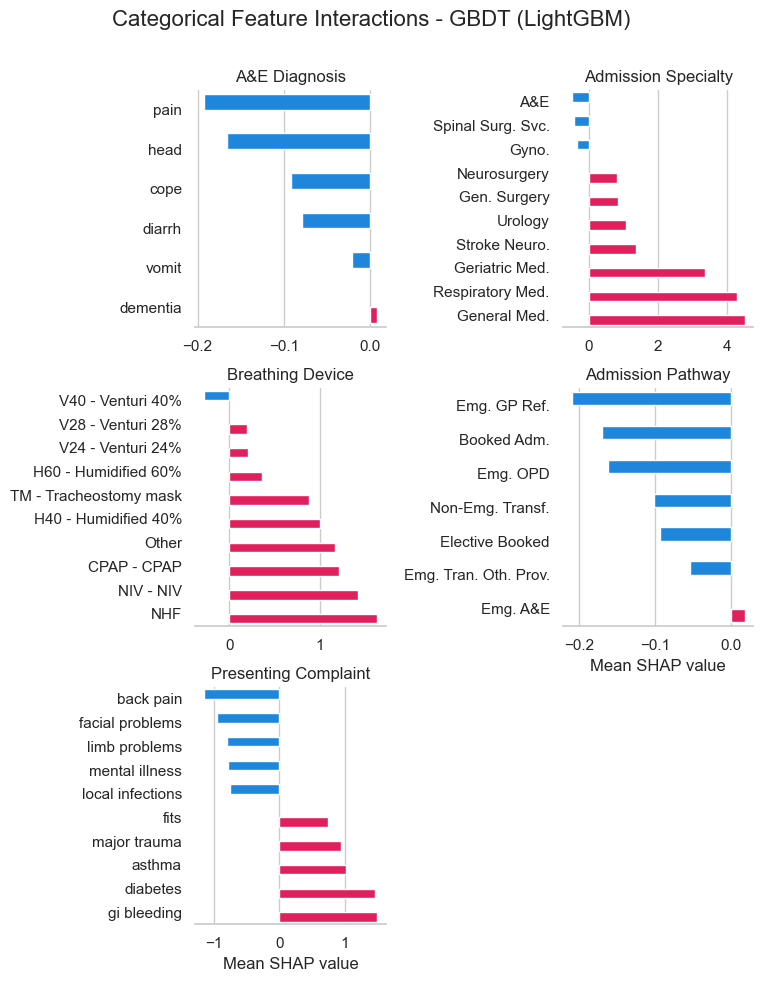

In [160]:
df['Hue'] = (df.SHAP > 0).astype(int)
sns.set_style('whitegrid')
g = sns.catplot(
    data=df, x='SHAP', y='Data', col='Feature', hue='Hue', palette=[shap.plots.colors.blue_rgb, shap.plots.colors.red_rgb],
    kind='bar', orient='h', sharey=False, sharex=False, legend=False, col_wrap=2, 
    col_order=['A&E Diagnosis', 'Admission Specialty', 'Breathing Device', 'Admission Pathway', 'Presenting Complaint']
    #col_order=['A&E Diagnosis', 'Presenting Complaint']
)
g.set_titles(template='{col_name}')
g.fig.set_size_inches(8,10)
g.fig.tight_layout()
g.set_ylabels('')
g.set_xlabels('Mean SHAP value')
g.despine(left=True)
g.fig.suptitle('Categorical Feature Interactions - GBDT (LightGBM)')
g.fig.subplots_adjust(top=0.9)
plt.savefig(f'{Notebook.IMAGE_DIR}/shap_categorical.svg', bbox_inches='tight', format='svg')

### Age & Sex

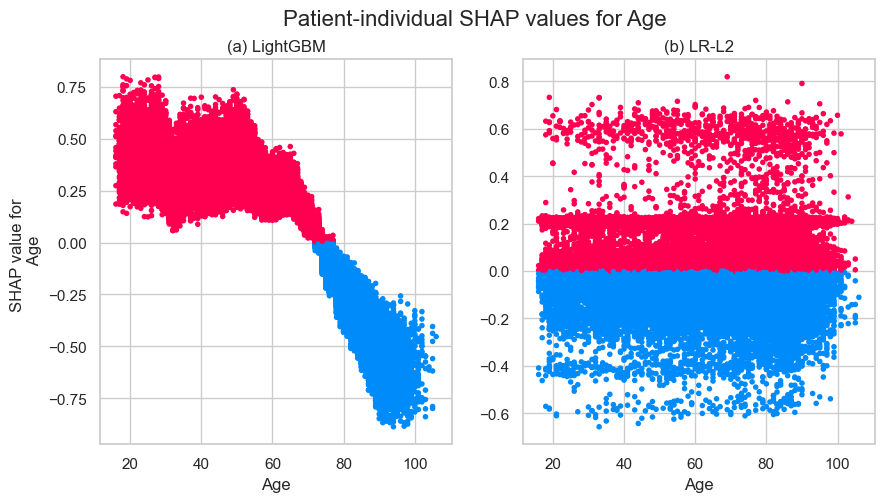

In [128]:
def comparison_scatter_plots(feature='Age', models=['LightGBM', 'L2Regression'], directory=Notebook.SYS_RESULTS_DIR, letters='ab', title=None, save=None):
    sns.set_style('whitegrid')
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    for i, model in enumerate(models):
        _, explanations, *_ = load_model(f'{model}_None_Within-1_with_notes_labs_and_hospital', directory)
        explanations = explanations[:,explanations.feature_names.index(feature)]
        df = pd.concat([pd.Series(explanations.values, name='Value'), pd.Series(explanations.data, name=feature)], axis=1)
        if feature == 'Temperature':
            df = df[df.Temperature > 34]

        df['Colour'] = df.Value.apply(lambda x: x < 0)
        sns.scatterplot(data=df, x=feature, y='Value', hue='Colour', ax=ax[i], legend=False, palette=[shap.plots.colors.red_rgb, shap.plots.colors.blue_rgb], linewidth=0, s=16)
        ax[i].set_title(f'({letters[i]}) {pretty_print_models[model]}')
        points = ax[i].collections[0]
        points.set_rasterized(True)

    ax[0].set_ylabel(f'SHAP value for \n {feature}')
    ax[1].set_ylabel('')

    if not title:
        title = f'Patient-individual SHAP values for {feature}'
    fig.suptitle(title)

    if save:
        fig.savefig(save, bbox_inches='tight', format='svg')

comparison_scatter_plots(save=f'{Notebook.IMAGE_DIR}/shap_scatter_age.svg')

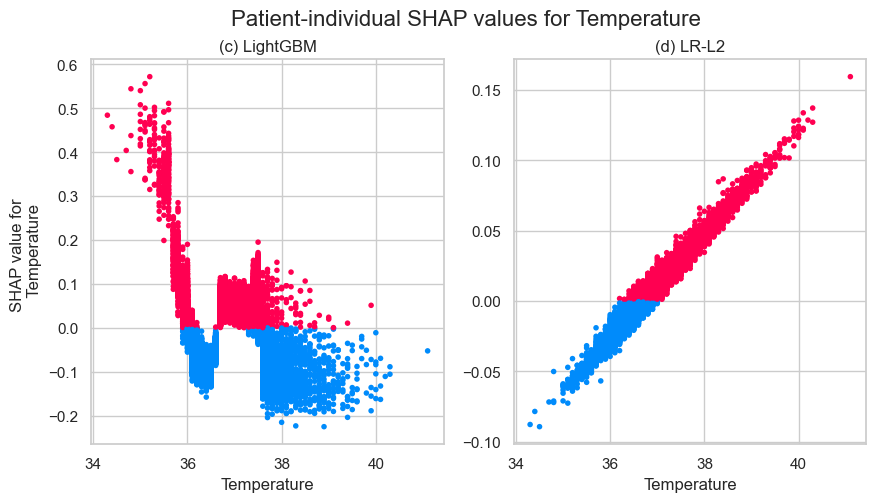

In [129]:
comparison_scatter_plots(feature='Temperature', save=f'{Notebook.IMAGE_DIR}/shap_scatter_temperature.svg', letters='cd')

### Misclassifications

In [110]:
from sklearn.metrics import precision_recall_curve

X_train, X_test, y_train, y_test = get_xy(scii, Estimator_LightGBM, scii.feature_group_combinations['with_notes_labs_and_hospital'])
_, recall, thresholds = precision_recall_curve(y_test, Y_PREDS['LightGBM_None_Within-1_with_notes_labs_and_hospital'])

In [111]:
sci_test[((y_pred_proba < thresholds[np.abs(recall-0.90).argmin()]) & y_test)].AandEPresentingComplaint.value_counts()

NameError: name 'y_pred_proba' is not defined

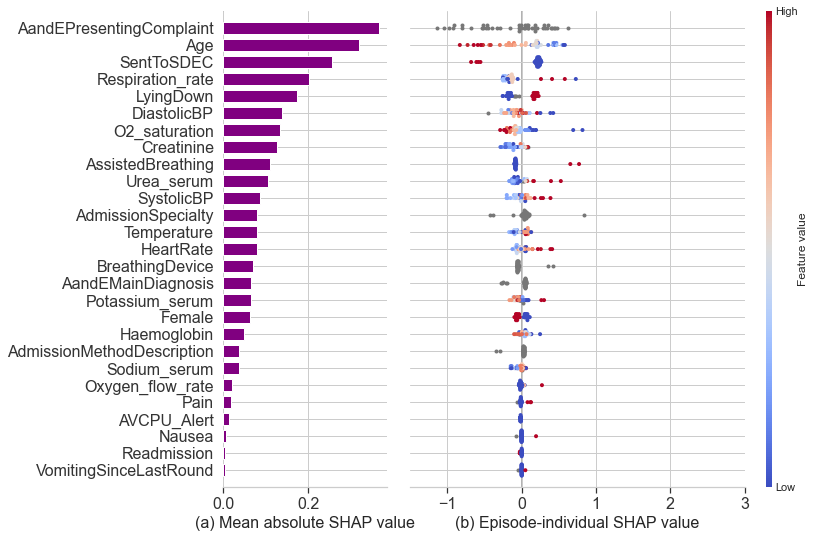

In [ ]:
_, explanations = load_model('LightGBM_None_Within-1_with_notes_labs_and_hospital', Notebook.SYS_RESULTS_DIR)
y_pred_proba = Y_PREDS['LightGBM_None_Within-1_with_notes_labs_and_hospital']
plot_shap_features_joint(
    explanations[np.where((y_pred_proba < thresholds[np.abs(recall-0.95).argmin()]) & y_test)], 
    max_display=250,
    figsize=(12, 8),
    wspace=-0.25,
    bar_aspect=0.04,
    topadjust=0.925,
)

In [ ]:

def lgbm_explanations(name='LightGBM_None_Within-1_with_notes_labs_and_hospital', directory=Notebook.SYS_RESULTS_DIR, save=None, title='Feature Interactions - GBDT (LightGBM)'):
    _, explanations = load_model(name, directory)
    explanations.feature_names = list(map(SCICols.pretty_print_columns.get, explanations.feature_names))
    plot_shap_features_joint(
        explanations, 
        max_display=250,
        figsize=(12, 8),
        wspace=-0.25,
        bar_aspect=0.04,
        topadjust=0.925,
        title=title,
        save=save
    )
    
lgbm_explanations(save=f'{Notebook.IMAGE_DIR}/shap_lgbm.png')

## Time

Vitals: 0.8522452367486444 -> 0.8059654752185418


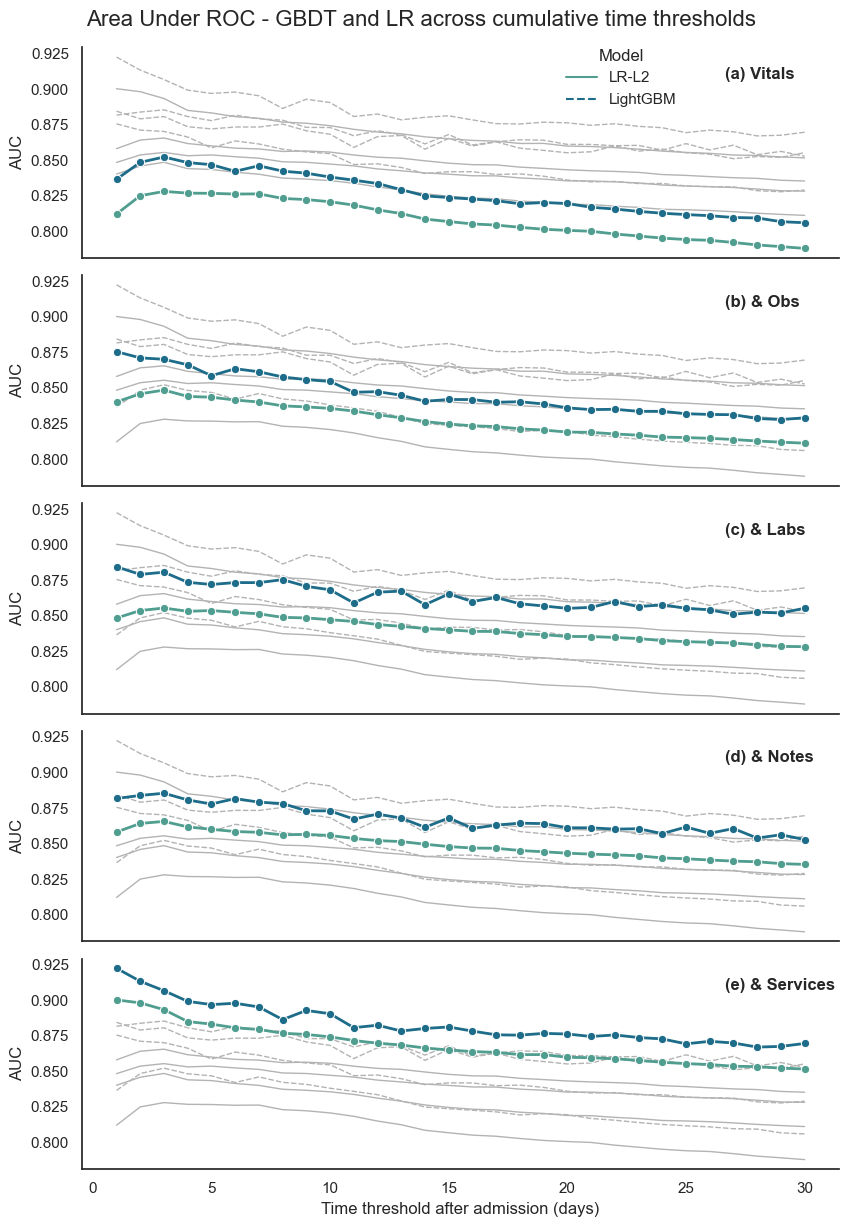

In [162]:
def timeseries_relplot(metrics, save=None):
    df = metrics.copy().rename(columns=dict(estimator='Model'))
    df = df[df.features.isin(select_feature_groups.keys())]
    df.features = df.features.replace(dict(
        news='(a) Vitals',
        news_with_phenotype='(b) & Obs',
        with_labs = '(c) & Labs',
        with_notes_and_labs = '(d) & Notes',
        with_notes_labs_and_hospital = '(e) & Services'
    ))
    df.Model = df.Model.replace(pretty_print_models)
    sns.set_theme(style="white")
    g = sns.relplot(
            data=df, x='outcome_within', y='AUC', hue='Model', col='features', marker='o',
        kind='line', palette='crest', linewidth=2, zorder=5, col_wrap=1, height=2.5, aspect=3.5
    )
    g.legend.legendHandles[1].set_linestyle('--')
    sns.move_legend(g, 'upper right', bbox_to_anchor=(0.7, 0.96), frameon=False)
    subp = [(i, features, ax) for i, (features, ax) in enumerate(g.axes_dict.items())]
    for i, features, ax in subp:
        ax.text(.85, .85, features, transform=ax.transAxes, fontweight='bold')
        line = sns.lineplot(
            data=df, x='outcome_within', y='AUC', units='features', style='Model', 
            estimator=None, color='.7', linewidth=1, ax=ax, legend=False
        )
    g.set_titles("")
    g.set_axis_labels("Time threshold after admission (days)", "AUC")
    g.tight_layout()
    g.fig.suptitle('Area Under ROC - GBDT and LR across cumulative time thresholds', x=0.43)
    g.fig.subplots_adjust(top=0.95)
    if save:
        plt.savefig(save, bbox_inches='tight', format='svg')

    mask = (df.Model == 'LightGBM') & (df.features=='(a) Vitals')
    print(f'Vitals: {df[mask].AUC.max()} -> {df[mask].AUC.min()}')

METRICS_TIME, _ = load_results(Notebook.TIME_RESULTS_DIR)
timeseries_relplot(METRICS_TIME, save=f'{Notebook.IMAGE_DIR}/timeseries_auc.svg')

In [ ]:
model, _ = load_model('LightGBM_None_Within-1_news', Notebook.SYS_RESULTS_DIR)

In [ ]:
from sklearn.calibration import CalibratedClassifierCV
y_crit, y_mort, y_icu = (
    sci_test.derive_critical_event(return_series=True), 
    sci_test.derive_death_within(return_series=True), 
    sci_test.derive_critical_care(return_series=True)
)
y_train_crit, y_train_mort, y_train_icu = (
    sci_train.derive_critical_event(return_series=True), 
    sci_train.derive_death_within(return_series=True), 
    sci_train.derive_critical_care(return_series=True)
)

,Accuracy,Precision,Recall,AP,F2 Score,AUC,AUC_CI
LGBM,,,,,,,
Critical event,0.928391,0.776471,0.022657,0.332553,0.028116,0.779022,0.779 (0.769-0.786)
Mortality only,0.995977,0.247059,0.177966,0.144437,0.188510,0.914547,0.915 (0.868-0.948)
Critical care,0.977888,0.164706,0.016908,0.132036,0.020606,0.837761,0.838 (0.826-0.851)


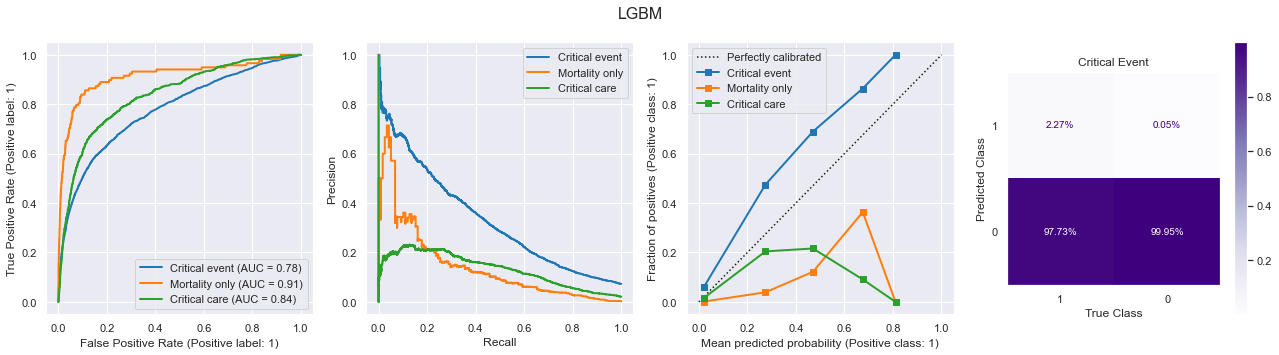

In [ ]:
evaluate_all_outcomes(y_crit, y_mort, y_icu, model.predict(X_test), model.predict_proba(X_test)[:,1], 'LGBM', n_resamples=99)

In [ ]:
X_train, X_test, y_train, y_test = get_xy(scii, Estimator_LightGBM, scii.feature_group_combinations['news'])

### SHAP

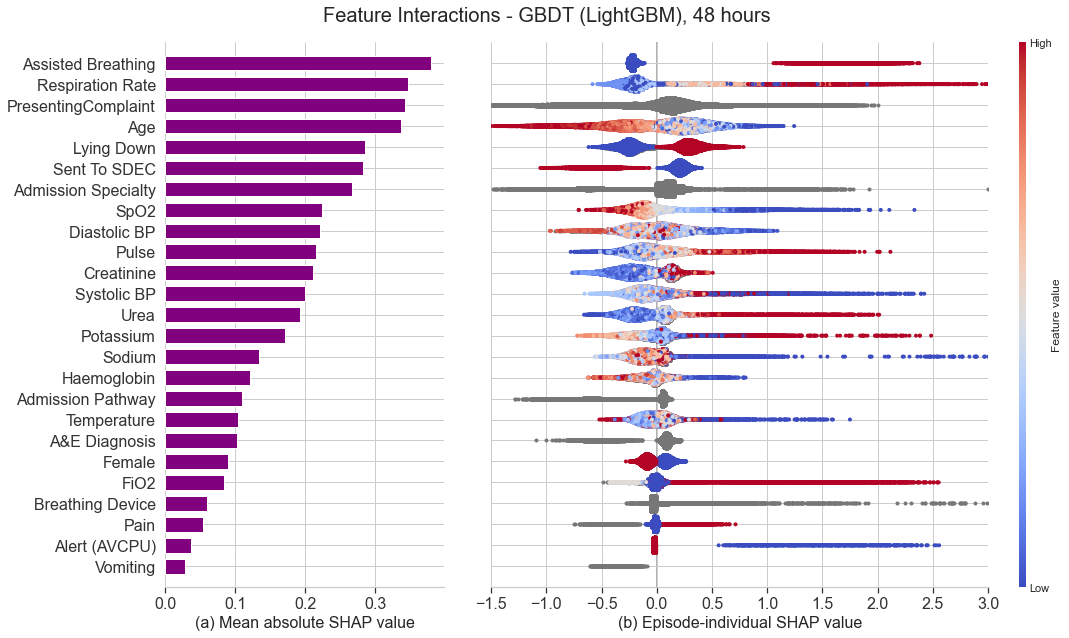

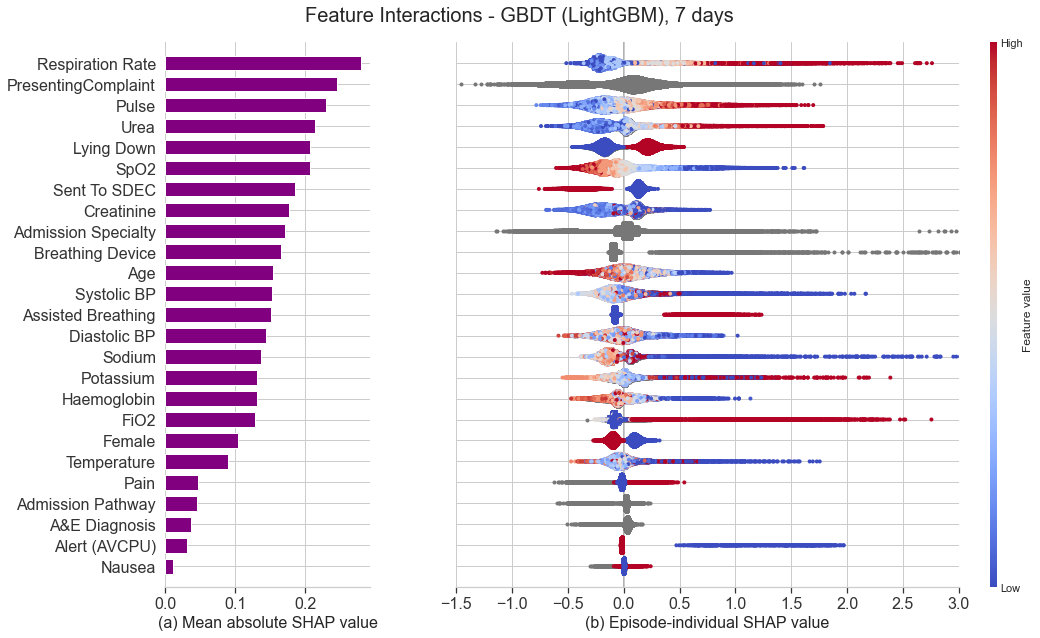

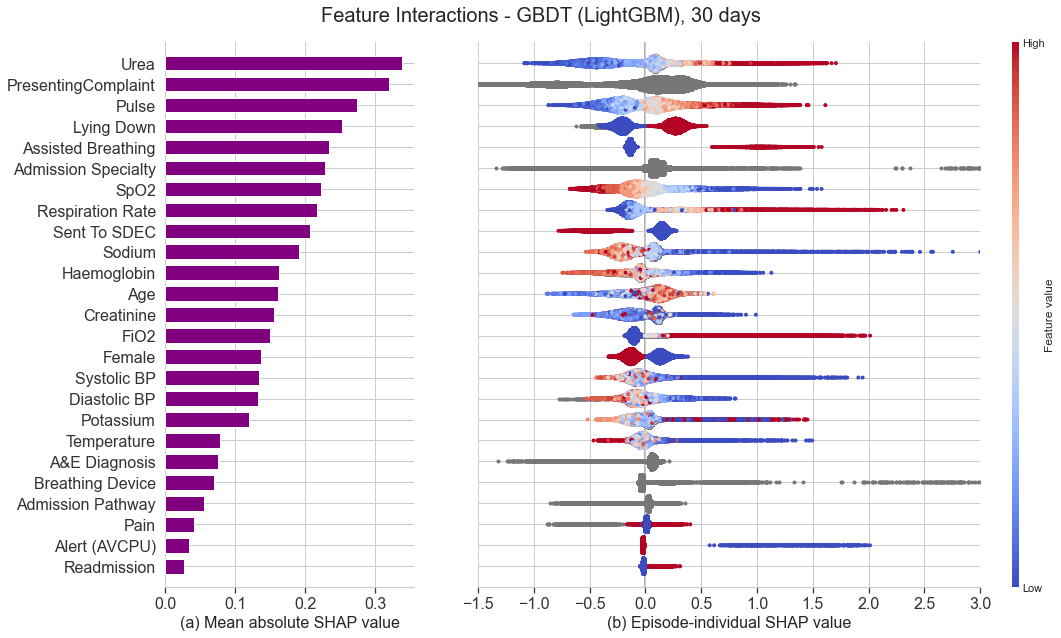

In [ ]:
def lgbm_explanations(name='LightGBM_None_Within-1_with_notes_labs_and_hospital', directory=Notebook.SYS_RESULTS_DIR, save=None, title='Feature Interactions - GBDT (LightGBM)'):
    _, explanations = load_model(name, directory)
    explanations.feature_names = list(map(SCICols.pretty_print_columns.get, explanations.feature_names))
    plot_shap_features_joint(
        explanations, 
        max_display=25,
        figsize=(16, 9),
        wspace=-0.2,
        bar_aspect=0.03,
        topadjust=0.925,
        title=title,
        save=save
    )
    
lgbm_explanations(save=f'{Notebook.IMAGE_DIR}/shap_lgbm_2.png', name='LightGBM_None_Within-2_with_notes_labs_and_hospital', directory=Notebook.TIME_PERSISTED_RESULTS_DIR, title='Feature Interactions - GBDT (LightGBM), 48 hours')
lgbm_explanations(save=f'{Notebook.IMAGE_DIR}/shap_lgbm_7.png', name='LightGBM_None_Within-7_with_notes_labs_and_hospital', directory=Notebook.TIME_PERSISTED_RESULTS_DIR, title='Feature Interactions - GBDT (LightGBM), 7 days')
lgbm_explanations(save=f'{Notebook.IMAGE_DIR}/shap_lgbm_30.png', name='LightGBM_None_Within-30_with_notes_labs_and_hospital', directory=Notebook.TIME_PERSISTED_RESULTS_DIR, title='Feature Interactions - GBDT (LightGBM), 30 days')


## Hyperparameters

In [81]:
def hyperparameters():
   # names = [f'{model}_None_Within-1_{feature}' for model in pretty_print_models.keys() for feature in select_feature_groups.keys()]
    params = [
        dict(
            Model=pretty_print_models[model],
            Features=select_feature_groups[features],
            Param=param.split('__')[1],
            Value=str(round(value, 4)) if type(value) == float else value
        ) for model in pretty_print_models.keys() for features in select_feature_groups.keys()
        for param, value in optuna.load_study(
            study_name =f'{model}_None_Within-1_{features}', storage=f'sqlite:///{Notebook.SYS_RESULTS_DIR}/{model}.db'
        ).best_params.items()
    ]
    return pd.DataFrame(params).pivot(index=['Model', 'Param'], columns='Features', values='Value')[select_feature_groups.values()].fillna('None')

params = hyperparameters()
params

Features                        Vitals      & Obs     & Labs    & Notes  \
Model     Param                                                           
LR        class_weight            None       None       None       None   
LR-EN     C                     0.0592     8.4126     1.1313     8.2228   
          class_weight            None       None       None       None   
          l1_ratio              0.4133      0.355     0.9356     0.5862   
LR-L1     C                     4.1169     2.8061     7.6951     4.4909   
          class_weight            None       None   balanced   balanced   
LR-L2     C                     5.7762     8.6765     9.9825     9.9151   
          class_weight            None       None       None       None   
LightGBM  colsample_bytree      0.6075      0.989     0.5526     0.4737   
          is_unbalance            True      False      False      False   
          min_child_samples        120        147         73         23   
          num_leaves                29         63         16        202   
          reg_alpha             2.6785     0.0402     1.5138     8.8073   
          reg_lambda            9.9052     0.0009     0.0941     0.0024   
          scale_pos_weight        None         53          2          4   
          subsample             0.8714      0.958     0.5702     0.9042   
          subsample_freq             4          4          1          2   
LinearSVM alpha                 0.0032     0.0004     0.0002     0.0011   
          class_weight        balanced       None       None       None   
XGBoost   alpha                    0.0        0.0        0.0        0.0   
          colsample_bytree      0.8389     0.6157     0.6273     0.4414   
          eta                   0.0196     0.0454     0.0231        0.0   
          gamma                    0.0        0.0     0.0005        0.0   
          grow_policy        lossguide  lossguide  lossguide  depthwise   
          lambda                0.0372     0.0019     0.0624      0.157   
          max_depth                  9          7          9          9   
          min_child_weight           8          9          6          5   
          scale_pos_weight           3          6          6         15   
          subsample             0.2505     0.7236     0.4115     0.3563   
          tree_method           approx       hist     approx     approx   

Features                    & Services  
Model     Param                         
LR        class_weight            None  
LR-EN     C                     7.0032  
          class_weight            None  
          l1_ratio              0.8086  
LR-L1     C                     0.2121  
          class_weight            None  
LR-L2     C                     3.5386  
          class_weight            None  
LightGBM  colsample_bytree      0.4804  
          is_unbalance           False  
          min_child_samples        147  
          num_leaves                13  
          reg_alpha             0.0001  
          reg_lambda            9.5277  
          scale_pos_weight           2  
          subsample             0.4902  
          subsample_freq             1  
LinearSVM alpha                 0.0005  
          class_weight            None  
XGBoost   alpha                    0.0  
          colsample_bytree       0.597  
          eta                   0.2193  
          gamma                    0.0  
          grow_policy        lossguide  
          lambda                0.3922  
          max_depth                  3  
          min_child_weight           4  
          scale_pos_weight          81  
          subsample             0.9937  
          tree_method           approx

In [82]:
params.index = params.index.set_levels([f'\\verb|{_}|' for _ in params.index.levels[1]], level=1)

In [83]:
print(params.to_latex(multirow=True, bold_rows=False, column_format='llrrrrr', escape=False, formatters=[lambda x: f'\\verb|{x}|' for _ in range(5)]).replace('\\textbackslash verb', '\\verb').replace('& \\textbf{', '& \\verb{'))

\begin{tabular}{llrrrrr}
\toprule
        & Features &            Vitals &             & Obs &            & Labs &           & Notes &        & Services \\
Model & Param &                   &                   &                   &                   &                   \\
\midrule
LR & \verb|class_weight| &       \verb|None| &       \verb|None| &       \verb|None| &       \verb|None| &       \verb|None| \\
\multirow{3}{*}{LR-EN} & \verb|C| &     \verb|0.0592| &     \verb|8.4126| &     \verb|1.1313| &     \verb|8.2228| &     \verb|7.0032| \\
        & \verb|class_weight| &       \verb|None| &       \verb|None| &       \verb|None| &       \verb|None| &       \verb|None| \\
        & \verb|l1_ratio| &     \verb|0.4133| &      \verb|0.355| &     \verb|0.9356| &     \verb|0.5862| &     \verb|0.8086| \\
\cline{1-7}
\multirow{2}{*}{LR-L1} & \verb|C| &     \verb|4.1169| &     \verb|2.8061| &     \verb|7.6951| &     \verb|4.4909| &     \verb|0.2121| \\
        & \verb|class_weight| &       \ver

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.


## Bias

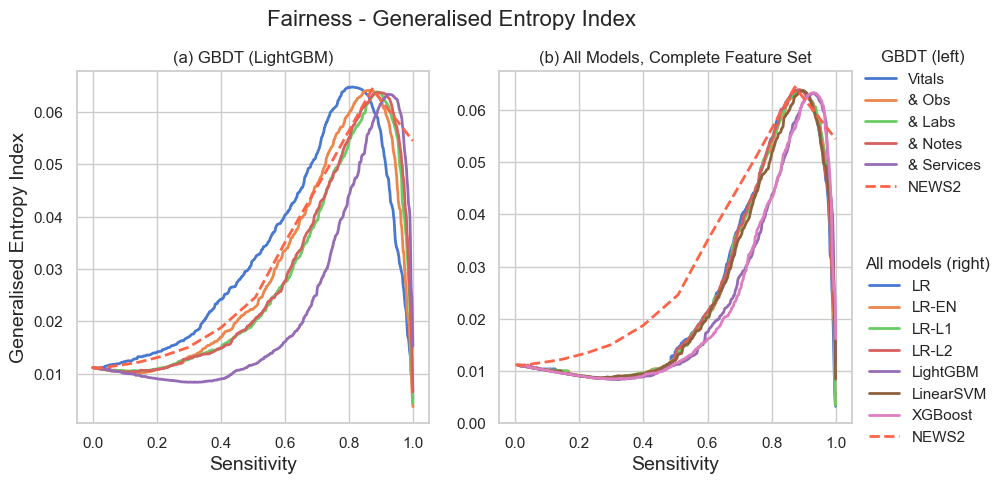

In [112]:
from aif360.sklearn.metrics import generalized_entropy_error, between_group_generalized_entropy_error
def generalized_entropy_curve(y_true, y_pred_proba, prot_attr=None, function=generalized_entropy_error):
    _, recall, thresholds = precision_recall_curve(y_true, y_pred_proba)
    if function == generalized_entropy_error:
        r = [function(y_true, np.where(y_pred_proba > _, 1, 0)) for _ in thresholds]
    elif function == between_group_generalized_entropy_error:
        r = [
            between_group_generalized_entropy_error(y_true, np.where(y_pred_proba > _, 1, 0), prot_attr=prot_attr)
            for _ in thresholds]
    return recall[:-1], r

def plot_entropy_curves(y_true, y_preds, prot_attr=None, baseline_key=None, ax=None, palette=sns.color_palette("deep"), title='Equalised Odds', function=generalized_entropy_error):
    no_ax = ax is None
    if no_ax:
        sns.set_style("white")
        plt.rc("axes", titlesize=14)
        fig, ax = plt.subplots(1, 1, figsize=(6, 6))

    for idx, (modelkey, y_pred_proba) in enumerate(y_preds.items()):
        linestyle = "--" if modelkey == baseline_key else "-"
        color = "tomato" if modelkey == baseline_key else palette[idx]
        x, y = generalized_entropy_curve(y_true, y_pred_proba, prot_attr, function=function)
        sns.lineplot(x=x, y=y, label=modelkey, linewidth=2, linestyle=linestyle, color=color, ax=ax)
    
    ax.legend(loc="upper right")
    # sns.move_legend(ax, "center left", bbox_to_anchor=(1, 0.5))
    ax.set_title(title)
    ax.set_xlabel("Sensitivity")
    if function == generalized_entropy_error:
        ax.set_ylabel("Generalised Entropy Index")
    elif function == between_group_generalized_entropy_error:
        ax.set_ylabel("Between-Group Unfairness")

def entropy_comparison(metrics, y_preds, prot_attr=None, save=None, function=generalized_entropy_error, title='Fairness - Generalised Entropy Index'):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    sns.set_style("whitegrid")
    for _ in ax:
        _.set_box_aspect(1)
    
    y_test = sci_test.derive_critical_event(within=1, return_series=True).loc[y_preds.index]
    baseline_news = {'NEWS2': sci_test.loc[y_test.index, 'NEWS_score']}
    y_preds_l, y_preds_r = model_preds_across_features(metrics, y_preds, 'LightGBM'), all_model_preds(metrics, y_preds)

    plot_entropy_curves(y_test, y_preds_l | baseline_news, ax=ax[0], title='(a) GBDT (LightGBM)', baseline_key='NEWS2', palette=sns.color_palette('muted'), function=function, prot_attr=prot_attr)
    plot_entropy_curves(y_test, y_preds_r | baseline_news, ax=ax[1], title='(b) All Models, Complete Feature Set', baseline_key='NEWS2', palette=sns.color_palette('muted'), function=function, prot_attr=prot_attr)

    sns.move_legend(ax[0], "upper left", bbox_to_anchor=(2.2, 1.1), frameon=False, title='GBDT (left)')
    sns.move_legend(ax[1], "lower left", bbox_to_anchor=(1, -0.1), frameon=False, title='All models (right)')
    ax[1].set_ylabel(None)
   # fig.tight_layout(h_pad=0.5, w_pad=0.5)
    fig.subplots_adjust(top=0.9)
    fig.suptitle(title)
    if save:
        plt.savefig(save, bbox_inches='tight', format='svg')
entropy_comparison(METRICS, Y_PREDS, save=f'{Notebook.IMAGE_DIR}/entropy.svg')        

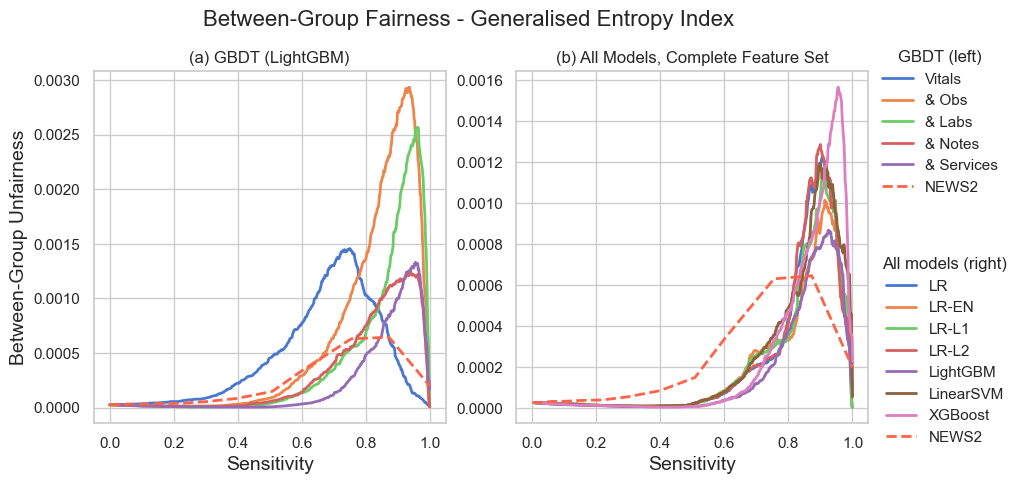

In [113]:
entropy_comparison(METRICS, Y_PREDS, function=between_group_generalized_entropy_error, prot_attr=sci_test.derive_critical_event(return_series=True).set_axis(sci_test[['Female', 'AgeBand']]).index, save=f'{Notebook.IMAGE_DIR}/entropy_between.svg', title='Between-Group Fairness - Generalised Entropy Index')

In [78]:
from aif360.sklearn.metrics.metrics import intersection, smoothed_base_rate
from itertools import permutations

def soft_base_rate(y_true, y_pred=None, *, concentration=1.0, pos_label=1, sample_weight=None):
    return (np.sum(y_true) + concentration)/(y_true.shape[0] + concentration)

def soft_selection_rate(y_true, y_pred, *, concentration=1.0, pos_label=1, sample_weight=None):
    return soft_base_rate(y_pred, concentration=concentration, pos_label=pos_label, sample_weight=sample_weight)

def soft_edf(y_true, y_pred=None, *, prot_attr=None, pos_label=1, concentration=1.0, sample_weight=None):
    rate = soft_base_rate if y_pred is None else soft_selection_rate
    sbr = intersection(rate, y_true, y_pred, prot_attr=prot_attr)
    logsbr = np.log(sbr)
    pos_ratio = max(abs(i - j) for i, j in permutations(logsbr, 2))
    lognegsbr = np.log(1 - np.array(sbr))
    neg_ratio = max(abs(i - j) for i, j in permutations(lognegsbr, 2))
    return max(pos_ratio, neg_ratio)

def soft_df_bias_amplification(y_true, y_pred, prot_attr, pos_label=1, concentration=1.0, sample_weight=None):
    eps_true = soft_edf(y_true, prot_attr=prot_attr, pos_label=pos_label,
                            concentration=concentration,
                            sample_weight=sample_weight)
    eps_pred = soft_edf(y_true, y_pred, prot_attr=prot_attr,
                            pos_label=pos_label, concentration=concentration,
                            sample_weight=sample_weight)
    return eps_pred - eps_true

def bootstrap_bias_amplification(y_true, y_score, prot_attr, n_resamples=99):
    center = soft_df_bias_amplification(y_true, y_score, prot_attr)
    res = st.bootstrap(
        data=(y_true.to_numpy(), y_score.to_numpy(), prot_attr.to_numpy()),
        statistic=soft_df_bias_amplification,
        confidence_level=0.95,
        method="percentile",
        n_resamples=n_resamples,
        vectorized=False,
        paired=True,
        random_state=42,
    )
    return res.confidence_interval.low, center, res.confidence_interval.high

In [79]:
def calc_bias_amplifications():
    df = sci_test[sci_test.AgeBand != '16 and Under'].copy()
    y_test = df.CriticalEvent
    prot_attrs = dict(
        Age=df.AgeBand,
        Sex=df.Female,
        Both=y_test.set_axis(df[['AgeBand', 'Female']]).index,
    )

    metrics = METRICS[(METRICS.resampler=='None')&(METRICS.features.isin(select_feature_groups.keys()))].copy()
    get_dict = lambda low, mid, high: dict(
            Bias_Amp = mid,
            Bias_Amp_Lower = low,
            Bias_Amp_Upper = high
        )
  
    df = pd.DataFrame((
        dict(
            name=_['name'],
            estimator=pretty_print_models[_['estimator']],
            features=select_feature_groups[_['features']],
            protected=attr_key
        )| get_dict(*bootstrap_bias_amplification(
            y_test, 
            Y_PREDS.loc[df.index, _['name']],
            prot_attr, 
            n_resamples=9
        )) for _ in metrics.to_dict(orient='records') for attr_key, prot_attr in prot_attrs.items()
    ))

    df['Bias'] = df.Bias_Amp.map('{:.3f}'.format) + ' (' + df.Bias_Amp_Lower.map('{:.3f}'.format) + ' - ' + df.Bias_Amp_Upper.map('{:.3f}'.format) + ')'
    print(f'Median: {df[df.protected=="Both"].Bias_Amp.median()}')

    return df.pivot(index=['features', 'estimator'], columns=['protected'], values='Bias')[['Sex', 'Age', 'Both']].loc[select_feature_groups.values()]


df = calc_bias_amplifications()
df

Median: -0.5773393278526169


protected                                  Sex                       Age  \
features   estimator                                                       
Vitals     LR         -0.240 (-0.374 - -0.115)     0.107 (0.060 - 0.267)   
           LR-EN      -0.240 (-0.373 - -0.114)     0.110 (0.065 - 0.269)   
           LR-L1      -0.240 (-0.374 - -0.115)     0.106 (0.060 - 0.267)   
           LR-L2      -0.240 (-0.374 - -0.115)     0.107 (0.060 - 0.267)   
           LightGBM   -0.245 (-0.396 - -0.123)    0.030 (-0.019 - 0.194)   
           LinearSVM  -0.253 (-0.385 - -0.125)     0.200 (0.142 - 0.359)   
           XGBoost    -0.242 (-0.392 - -0.125)     0.089 (0.045 - 0.252)   
& Obs      LR           0.050 (-0.114 - 0.114)  -0.483 (-0.554 - -0.287)   
           LR-EN        0.050 (-0.115 - 0.113)  -0.484 (-0.555 - -0.288)   
           LR-L1        0.049 (-0.116 - 0.112)  -0.484 (-0.555 - -0.288)   
           LR-L2        0.051 (-0.115 - 0.114)  -0.484 (-0.555 - -0.288)   
           LightGBM     0.006 (-0.140 - 0.081)  -0.320 (-0.407 - -0.138)   
           LinearSVM  -0.147 (-0.271 - -0.055)  -0.687 (-0.750 - -0.554)   
           XGBoost     -0.022 (-0.174 - 0.058)  -0.298 (-0.349 - -0.101)   
& Labs     LR           0.074 (-0.098 - 0.143)  -0.500 (-0.564 - -0.312)   
           LR-EN        0.074 (-0.099 - 0.141)  -0.499 (-0.562 - -0.311)   
           LR-L1        0.095 (-0.079 - 0.168)  -0.504 (-0.552 - -0.314)   
           LR-L2        0.074 (-0.098 - 0.143)  -0.499 (-0.564 - -0.312)   
           LightGBM     0.034 (-0.123 - 0.111)  -0.317 (-0.388 - -0.144)   
           LinearSVM   -0.047 (-0.172 - 0.040)  -0.592 (-0.671 - -0.406)   
           XGBoost     -0.015 (-0.165 - 0.067)  -0.329 (-0.404 - -0.140)   
& Notes    LR           0.065 (-0.110 - 0.139)  -0.475 (-0.539 - -0.285)   
           LR-EN        0.069 (-0.109 - 0.143)  -0.476 (-0.543 - -0.286)   
           LR-L1        0.076 (-0.104 - 0.155)  -0.499 (-0.556 - -0.310)   
           LR-L2        0.069 (-0.109 - 0.143)  -0.476 (-0.542 - -0.286)   
           LightGBM     0.013 (-0.132 - 0.084)  -0.313 (-0.371 - -0.131)   
           LinearSVM   -0.047 (-0.187 - 0.055)  -0.657 (-0.733 - -0.514)   
           XGBoost     -0.061 (-0.215 - 0.017)  -0.187 (-0.242 - -0.032)   
& Services LR           0.041 (-0.088 - 0.114)  -0.454 (-0.532 - -0.241)   
           LR-EN        0.047 (-0.085 - 0.120)  -0.459 (-0.538 - -0.244)   
           LR-L1        0.047 (-0.086 - 0.117)  -0.456 (-0.543 - -0.239)   
           LR-L2        0.050 (-0.083 - 0.123)  -0.459 (-0.539 - -0.244)   
           LightGBM     0.004 (-0.118 - 0.086)  -0.263 (-0.312 - -0.048)   
           LinearSVM  -0.137 (-0.229 - -0.043)  -0.579 (-0.647 - -0.399)   
           XGBoost     -0.005 (-0.122 - 0.078)  -0.260 (-0.322 - -0.049)   

protected                                 Both  
features   estimator                            
Vitals     LR         -0.213 (-0.343 - -0.010)  
           LR-EN      -0.211 (-0.337 - -0.007)  
           LR-L1      -0.214 (-0.344 - -0.011)  
           LR-L2      -0.213 (-0.343 - -0.011)  
           LightGBM   -0.312 (-0.428 - -0.089)  
           LinearSVM   -0.106 (-0.229 - 0.077)  
           XGBoost    -0.250 (-0.348 - -0.036)  
& Obs      LR         -0.617 (-0.773 - -0.441)  
           LR-EN      -0.619 (-0.775 - -0.442)  
           LR-L1      -0.619 (-0.774 - -0.442)  
           LR-L2      -0.618 (-0.776 - -0.442)  
           LightGBM   -0.465 (-0.622 - -0.302)  
           LinearSVM  -1.016 (-1.111 - -0.826)  
           XGBoost    -0.494 (-0.636 - -0.298)  
& Labs     LR         -0.604 (-0.769 - -0.431)  
           LR-EN      -0.602 (-0.771 - -0.431)  
           LR-L1      -0.589 (-0.685 - -0.351)  
           LR-L2      -0.602 (-0.768 - -0.430)  
           LightGBM   -0.416 (-0.583 - -0.265)  
           LinearSVM  -0.660 (-0.805 - -0.464)  
           XGBoost    -0.514 (-0.648 - -0.324)  
& Notes    LR         -0.577 (-0.760 - -0.404)  
           

In [80]:
print(df.loc[select_feature_groups.values()].to_latex(bold_rows=True, multicolumn=True, multirow=True, column_format='llrrr'))

\begin{tabular}{llrrr}
\toprule
           & \textbf{protected} &                       Sex &                       Age &                      Both \\
\textbf{features} & \textbf{estimator} &                           &                           &                           \\
\midrule
\multirow{7}{*}{\textbf{Vitals}} & \textbf{LR} &  -0.240 (-0.374 - -0.115) &     0.107 (0.060 - 0.267) &  -0.213 (-0.343 - -0.010) \\
           & \textbf{LR-EN} &  -0.240 (-0.373 - -0.114) &     0.110 (0.065 - 0.269) &  -0.211 (-0.337 - -0.007) \\
           & \textbf{LR-L1} &  -0.240 (-0.374 - -0.115) &     0.106 (0.060 - 0.267) &  -0.214 (-0.344 - -0.011) \\
           & \textbf{LR-L2} &  -0.240 (-0.374 - -0.115) &     0.107 (0.060 - 0.267) &  -0.213 (-0.343 - -0.011) \\
           & \textbf{LightGBM} &  -0.245 (-0.396 - -0.123) &    0.030 (-0.019 - 0.194) &  -0.312 (-0.428 - -0.089) \\
           & \textbf{LinearSVM} &  -0.253 (-0.385 - -0.125) &     0.200 (0.142 - 0.359) &   -0.106 (-0.229 - 0.077) \

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
